import all required library

In [1]:
import pandas as pd
import re
import string
from tqdm.notebook import tqdm
import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, ArrayDictionary, StopWordRemover
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
from gensim.summarization import summarize, keywords
from collections import Counter
from nltk.tokenize import word_tokenize

open csv file contains tweets to a dataframe

In [2]:
data = pd.read_csv("coba_2_label.csv")

data.head()

id_str                 created_at  \
0  1.323188e+18  2020-11-02 08:58:29+00:00   
1  1.323187e+18  2020-11-02 08:56:15+00:00   
2  1.323186e+18  2020-11-02 08:52:06+00:00   
3  1.323185e+18  2020-11-02 08:46:38+00:00   
4  1.323180e+18  2020-11-02 08:29:45+00:00   

                                              source  \
0  <a href="http://twitter.com/download/iphone" r...   
1  <a href="http://twitter.com/download/android" ...   
2  <a href="http://twittbot.net/" rel="nofollow">...   
3  <a href="http://twitter.com/download/android" ...   
4  <a href="http://twitter.com/download/android" ...   

                                                text       label  
0  i layk dah beyu\n\nyu du?\n\nyesh\n\nyu ar mah...  irrelevant  
1  Apa apaan nih, tiba tiba @Telkomsel ilang siny...     negatif  
2  Luhan Byu-Ti-Pul Byu-Ti-Pul Byu-Ti-Pul, Luhan ...  irrelevant  
3  siang siang dpt kouta gratis dri kak nindy, ma...     positif  
4  Saya sudah melaksanakan S3 Marketing tapi rewa...     negatif

double check the data

In [3]:
del data['id_str']

In [4]:
data.head()

created_at  \
0  2020-11-02 08:58:29+00:00   
1  2020-11-02 08:56:15+00:00   
2  2020-11-02 08:52:06+00:00   
3  2020-11-02 08:46:38+00:00   
4  2020-11-02 08:29:45+00:00   

                                              source  \
0  <a href="http://twitter.com/download/iphone" r...   
1  <a href="http://twitter.com/download/android" ...   
2  <a href="http://twittbot.net/" rel="nofollow">...   
3  <a href="http://twitter.com/download/android" ...   
4  <a href="http://twitter.com/download/android" ...   

                                                text       label  
0  i layk dah beyu\n\nyu du?\n\nyesh\n\nyu ar mah...  irrelevant  
1  Apa apaan nih, tiba tiba @Telkomsel ilang siny...     negatif  
2  Luhan Byu-Ti-Pul Byu-Ti-Pul Byu-Ti-Pul, Luhan ...  irrelevant  
3  siang siang dpt kouta gratis dri kak nindy, ma...     positif  
4  Saya sudah melaksanakan S3 Marketing tapi rewa...     negatif

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5596 entries, 0 to 5595
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  5596 non-null   object
 1   source      5579 non-null   object
 2   text        5596 non-null   object
 3   label       5592 non-null   object
dtypes: object(4)
memory usage: 175.0+ KB


double check on column 'label' and fix it if necessary. for example if some variable is still have null value, then fill it with true label wether it positif, negative, or irrelevant

In [6]:
data[pd.isnull(data["label"])]

created_at  \
476   2020-10-28 07:09:55+00:00   
2375  2020-11-09 14:39:38+00:00   
2516  2020-11-18 00:36:21+00:00   
3929  2020-11-23 08:55:13+00:00   

                                                 source  \
476   <a href="https://mobile.twitter.com" rel="nofo...   
2375  <a href="http://twitter.com/download/android" ...   
2516  <a href="http://twitter.com/download/iphone" r...   
3929  <a href="https://ifttt.com" rel="nofollow">IFT...   

                                                   text label  
476   ngeselin bgt baru isi byu yang aman jaya malah...   NaN  
2375  jaringan kamu kenapa sayang. ko jelek si akhir...   NaN  
2516  U not even care on artwork and copyright. Bila...   NaN  
3929  MARIO &amp; LUIGI 🔴🟢 \nvia /r/ MEDI-SHIKI\nby ...   NaN

In [7]:
data.loc[476]["text"]

'ngeselin bgt baru isi byu yang aman jaya malah keluar yang staycation 50gb 100rb :D'

In [8]:
data.loc[2375]["text"]

'jaringan kamu kenapa sayang. ko jelek si akhir2 ini. ada masalah, hmm? @byu_id'

In [9]:
data.loc[2516]["text"]

'U not even care on artwork and copyright. Bila aku kacau kerja kau terus kau tarik GM yer. Did have approved by ceo… https://t.co/JD9K5m7uNl'

In [10]:
data.loc[3929]["text"]

'MARIO &amp; LUIGI 🔴🟢 \nvia /r/ MEDI-SHIKI\nby /u/ gaming\n(https://t.co/EgTGma6Eko) #gaming'

In [11]:
data.loc[476]["label"] = "negatif"
data.loc[2375]["label"] = "negatif"
data.loc[2516]["label"] = "irrelevant"
data.loc[3929]["label"] = "irrelevant"

In [12]:
data["label"].value_counts()

negatif       2207
positif       1864
irrelevant    1525
Name: label, dtype: int64

In [13]:
data.loc[476]

created_at                            2020-10-28 07:09:55+00:00
source        <a href="https://mobile.twitter.com" rel="nofo...
text          ngeselin bgt baru isi byu yang aman jaya malah...
label                                                   negatif
Name: 476, dtype: object

In [14]:
data[pd.isnull(data["source"])]

created_at source  \
2475  2020-11-18 05:30:29+00:00    NaN   
2591  2020-11-17 10:30:11+00:00    NaN   
2610  2020-11-17 07:00:11+00:00    NaN   
2740  2020-11-09 19:00:28+00:00    NaN   
2893  2020-11-16 01:00:18+00:00    NaN   
2913  2020-11-15 16:30:27+00:00    NaN   
3178  2020-11-22 21:30:34+00:00    NaN   
3395  2020-11-22 02:30:27+00:00    NaN   
3563  2020-11-21 03:30:12+00:00    NaN   
3568  2020-11-21 03:00:13+00:00    NaN   
3623  2020-11-20 15:01:14+00:00    NaN   
4000  2020-11-24 02:30:26+00:00    NaN   
4016  2020-11-24 00:30:16+00:00    NaN   
4018  2020-11-24 00:00:12+00:00    NaN   
4458  2020-11-29 06:00:12+00:00    NaN   
5329  2020-11-26 19:37:39+00:00    NaN   
5493  2020-11-30 00:00:49+00:00    NaN   

                                                   text       label  
2475  NK65 Blumen \n by /u/kbartelamia \n \n https:/...  irrelevant  
2591  Maja X MT3 Susuwatari \n by /u/NAFAL44 \n \n h...  irrelevant  
2610  KBD8X MKII + MT3 Susuwatari \n by /u/Keebored1...  irrelevant  
2740  Alais \n by /u/haririjumain \n \n https://t.co...  irrelevant  
2893  Samurai on Nova \n by /u/Tack_Tau \n \n https:...  irrelevant  
2913  Finally, DSA Astrolokeys \n by /u/jerolan \n \...  irrelevant  
3178  GMK Ursa came in \n by /u/Swaedo \n \n https:/...  irrelevant  
3395  Godslayer Keypora \n by /u/OGBM \n \n https://...  irrelevant  
3563  KAT Eternal \n by /u/Saavy1 \n \n https://t.co...  irrelevant  
3568  Maja x Serika \n by /u/oletz \n \n https://t.c...  irrelevant  
3623  Casio Canoe \n by /u/tsepme7 \n \n https://t.c...  irrelevant  
4000  Polycarb Canoe Gen2 \n by /u/tsepme7 \n \n htt...  irrelevant  
4016  Monterey SMK 2gen clicky in box \n by /u/DeDuW...  irrelevant  
4018  Fujiwara Tofu Keyboard \n by /u/_vastrox_ \n \...  irrelevant  
4458  KB Nudes \n by /u/tsepme7 \n \n https://t.co/b...  irrelevant  
5329  Now playing on Pamtengo Radio: Zonga Kanjani b...  irrelevant  
5493  pamer info time🤝\npemakai byu? iya? bukan?\nka...  irrelevant

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5596 entries, 0 to 5595
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  5596 non-null   object
 1   source      5579 non-null   object
 2   text        5596 non-null   object
 3   label       5596 non-null   object
dtypes: object(4)
memory usage: 175.0+ KB


delete varable with null value

In [16]:
data = data.dropna(how='any',axis=0)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5579 entries, 0 to 5595
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  5579 non-null   object
 1   source      5579 non-null   object
 2   text        5579 non-null   object
 3   label       5579 non-null   object
dtypes: object(4)
memory usage: 217.9+ KB


In [18]:
data.describe()

created_at  \
count                        5579   
unique                       5457   
top     2020-11-09 22:51:38+00:00   
freq                            2   

                                                   source  \
count                                                5579   
unique                                                 92   
top     <a href="http://twitter.com/download/android" ...   
freq                                                 3706   

                                                     text    label  
count                                                5579     5579  
unique                                               5248        3  
top     Luhan Byu-Ti-Pul Byu-Ti-Pul Byu-Ti-Pul, Luhan ...  negatif  
freq                                                   70     2207

drop the duplicated data by tweets

In [19]:
data.drop_duplicates(subset ="text", 
                     keep = "first", inplace = True)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5248 entries, 0 to 5595
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  5248 non-null   object
 1   source      5248 non-null   object
 2   text        5248 non-null   object
 3   label       5248 non-null   object
dtypes: object(4)
memory usage: 205.0+ KB


reset the index

In [21]:
data.reset_index(drop=True, inplace=True)

In [22]:
data["label"].value_counts()

negatif       2167
positif       1807
irrelevant    1274
Name: label, dtype: int64

sorting the data by time when the tweets was created

In [23]:
data.sort_values("created_at", ascending = True)

data

created_at  \
0     2020-11-02 08:58:29+00:00   
1     2020-11-02 08:56:15+00:00   
2     2020-11-02 08:52:06+00:00   
3     2020-11-02 08:46:38+00:00   
4     2020-11-02 08:29:45+00:00   
...                         ...   
5243  2020-11-30 05:58:22+00:00   
5244  2020-11-30 05:47:33+00:00   
5245  2020-11-30 05:47:12+00:00   
5246  2020-11-30 05:45:40+00:00   
5247  2020-11-30 05:38:32+00:00   

                                                 source  \
0     <a href="http://twitter.com/download/iphone" r...   
1     <a href="http://twitter.com/download/android" ...   
2     <a href="http://twittbot.net/" rel="nofollow">...   
3     <a href="http://twitter.com/download/android" ...   
4     <a href="http://twitter.com/download/android" ...   
...                                                 ...   
5243  <a href="https://ifttt.com" rel="nofollow">IFT...   
5244  <a href="https://www.twitter.com/belift_fess" ...   
5245  <a href="http://twitter.com/download/android" ...   
5246  <a href="http://twitter.com/download/android" ...   
5247  <a href="http://twitter.com/download/android" ...   

                                                   text       label  
0     i layk dah beyu\n\nyu du?\n\nyesh\n\nyu ar mah...  irrelevant  
1     Apa apaan nih, tiba tiba @Telkomsel ilang siny...     negatif  
2     Luhan Byu-Ti-Pul Byu-Ti-Pul Byu-Ti-Pul, Luhan ...  irrelevant  
3     siang siang dpt kouta gratis dri kak nindy, ma...     positif  
4     Saya sudah melaksanakan S3 Marketing tapi rewa...     negatif  
...                                                 ...         ...  
5243  Hot🔥 : happy guru nanak jayanti\n\nposted by u...  irrelevant  
5244  [by_en-ge-ne]  Bawang sebentar hehe jangan lup...  irrelevant  
5245  Today’s #byUpedia\n\nKalo kuota yang tertera d...     positif  
5246  Oy @byu_id kpd byu yg terhormat\nKalo mau ngas...     negatif  
5247  bagi para pengguna by.u kira kira ini biar bis...     positif  

[5248 rows x 4 columns]

clean up data in column source from html elements

In [24]:
from bs4 import BeautifulSoup
from pymongo import MongoClient

data['source'] = data['source'].apply(lambda x: BeautifulSoup(x).get_text())

data['source']

0        Twitter for iPhone
1       Twitter for Android
2              twittbot.net
3       Twitter for Android
4       Twitter for Android
               ...         
5243                  IFTTT
5244           enhypenfess🧡
5245    Twitter for Android
5246    Twitter for Android
5247    Twitter for Android
Name: source, Length: 5248, dtype: object

display source list where tweets was created from

In [25]:
sources = list(set(data['source']))

print(sources)

['Twitt-RP', 'Nintendo Switch Share', 'AWA Music', 'subschfess', 'FenixApp', 'uns menfess', 'Twitter for Mac', 'twitter for iPhone XI pro maxx', 'UberSocial© PRO', 'Tumblr', 'CougarBoard Bot', 'DrupiFess', 'SongsInfo', 'IDCorner.Co.iD', 'UberSocial for iPhone', 'Hootsuite Inc.', 'WP2Zone', 'Twitter for Android', 'polbanfess', 'Pakai masker! Stay safe! -Bot-', 'enhypenfess🧡', 'GENK ANGEL SQUID', 'Ini sender', 'Socialbakers', 'Plume\xa0for\xa0Android', 'Rpgxg', 'Support Zona Karya', 'FS Poster', 'Jatimfess', 'AltentX P-Delta-8', 'Twitter Web App', 'STAY SAFE! TETAP PAKAI MASKER!', 'IFTTT', 'UNNES MENFESS🍌', 'WordPress.com', 'TweetDeck', 'ws ada disini!', 'indomycafe', 'Twitter for iPhone', 'ugm_fess', 'Games Menfess', 'DOR!', 'Buffer', 'DORbertanya', 'Echobox', 'AutoBase IPB Menfess', 'kookvbase', 'Harmoni Kediri Lagi', 'by jogmf', 'Sprout Social', 'ContentStudio.io', 'ツイタマ for Android', 'Revive Social App', 'BorderScanner', 'Twitter for iPad', 'UZoneID', 'Talon Android', '1m1c Auto Twee

filter out tweets from an 'unknown source' such as from bot etc, just pick the tweets from legal source

In [26]:
source = ['Twitter for iPad', 'Twitter for iPhone', 'Twitter for Android', 'Twitter for Mac', 'Twitter Web App']

In [27]:
data = data[data['source'].isin(source)]

data.head(20)

created_at               source  \
0   2020-11-02 08:58:29+00:00   Twitter for iPhone   
1   2020-11-02 08:56:15+00:00  Twitter for Android   
3   2020-11-02 08:46:38+00:00  Twitter for Android   
4   2020-11-02 08:29:45+00:00  Twitter for Android   
5   2020-11-02 07:28:43+00:00  Twitter for Android   
6   2020-11-02 06:51:44+00:00  Twitter for Android   
7   2020-11-02 06:41:32+00:00   Twitter for iPhone   
8   2020-11-02 06:31:45+00:00  Twitter for Android   
9   2020-11-02 06:03:12+00:00  Twitter for Android   
10  2020-11-02 05:57:22+00:00  Twitter for Android   
11  2020-11-02 05:57:00+00:00  Twitter for Android   
12  2020-11-02 05:54:15+00:00  Twitter for Android   
13  2020-11-02 05:49:47+00:00  Twitter for Android   
14  2020-11-02 05:30:21+00:00   Twitter for iPhone   
15  2020-11-02 05:14:40+00:00  Twitter for Android   
16  2020-11-02 05:01:18+00:00  Twitter for Android   
17  2020-11-02 04:56:40+00:00  Twitter for Android   
18  2020-11-02 04:51:31+00:00  Twitter for Android   
19  2020-11-02 04:48:32+00:00  Twitter for Android   
20  2020-11-02 04:31:14+00:00   Twitter for iPhone   

                                                 text       label  
0   i layk dah beyu\n\nyu du?\n\nyesh\n\nyu ar mah...  irrelevant  
1   Apa apaan nih, tiba tiba @Telkomsel ilang siny...     negatif  
3   siang siang dpt kouta gratis dri kak nindy, ma...     positif  
4   Saya sudah melaksanakan S3 Marketing tapi rewa...     negatif  
5   byu ngajak ribut bgt kalo mati listrik sinyaln...     negatif  
6   aneh banget kuota byu ku dah habis tp ini masi...     positif  
7             ini byu dr kemaren lelet bener deh hhhh     negatif  
8   hello,  @byu_id , mau isi pulsa kenapa belum b...     negatif  
9               Hallo kak nindy bisa cek dm ? @byu_id     positif  
10  ini telkom lagi bermasalah apa gimana deh?? wi...     negatif  
11  ga salah emang milih provider byU hampir setah...     positif  
12  min @byu_id mau aktivasi login gmail gini mulu...     negatif  
13  Wow, akhirnya ada provider internet yang bebas...     positif  
14      Makasih nindy @byu_id https://t.co/ZGfH6k5vZJ     positif  
15  Min kok kuota spotify sama youtube gak bisa di...     negatif  
16                  Coba tebak mana yang bener, gaes?  irrelevant  
17  TLSEL APA APAAN SIH INI BYU SAMA SIMPATI GAK B...     negatif  
18                          Mba @Afisk_ yu sri di jak  irrelevant  
19                            Byu jelek bgt tumben 😩😭     negatif  
20  Selamat 6 monthiversary, makasih ya kuota grat...     positif

In [28]:
#data.to_csv("coba_fix_source.csv", index=False)

delete all irrelevant tweets

In [29]:
data = data[~data.label.str.contains("irrelevant")]

data.reset_index(drop=True, inplace=True)

data.head(20)

created_at               source  \
0   2020-11-02 08:56:15+00:00  Twitter for Android   
1   2020-11-02 08:46:38+00:00  Twitter for Android   
2   2020-11-02 08:29:45+00:00  Twitter for Android   
3   2020-11-02 07:28:43+00:00  Twitter for Android   
4   2020-11-02 06:51:44+00:00  Twitter for Android   
5   2020-11-02 06:41:32+00:00   Twitter for iPhone   
6   2020-11-02 06:31:45+00:00  Twitter for Android   
7   2020-11-02 06:03:12+00:00  Twitter for Android   
8   2020-11-02 05:57:22+00:00  Twitter for Android   
9   2020-11-02 05:57:00+00:00  Twitter for Android   
10  2020-11-02 05:54:15+00:00  Twitter for Android   
11  2020-11-02 05:49:47+00:00  Twitter for Android   
12  2020-11-02 05:30:21+00:00   Twitter for iPhone   
13  2020-11-02 05:14:40+00:00  Twitter for Android   
14  2020-11-02 04:56:40+00:00  Twitter for Android   
15  2020-11-02 04:48:32+00:00  Twitter for Android   
16  2020-11-02 04:31:14+00:00   Twitter for iPhone   
17  2020-11-02 04:17:19+00:00  Twitter for Android   
18  2020-11-02 04:08:52+00:00      Twitter Web App   
19  2020-11-02 03:37:43+00:00  Twitter for Android   

                                                 text    label  
0   Apa apaan nih, tiba tiba @Telkomsel ilang siny...  negatif  
1   siang siang dpt kouta gratis dri kak nindy, ma...  positif  
2   Saya sudah melaksanakan S3 Marketing tapi rewa...  negatif  
3   byu ngajak ribut bgt kalo mati listrik sinyaln...  negatif  
4   aneh banget kuota byu ku dah habis tp ini masi...  positif  
5             ini byu dr kemaren lelet bener deh hhhh  negatif  
6   hello,  @byu_id , mau isi pulsa kenapa belum b...  negatif  
7               Hallo kak nindy bisa cek dm ? @byu_id  positif  
8   ini telkom lagi bermasalah apa gimana deh?? wi...  negatif  
9   ga salah emang milih provider byU hampir setah...  positif  
10  min @byu_id mau aktivasi login gmail gini mulu...  negatif  
11  Wow, akhirnya ada provider internet yang bebas...  positif  
12      Makasih nindy @byu_id https://t.co/ZGfH6k5vZJ  positif  
13  Min kok kuota spotify sama youtube gak bisa di...  negatif  
14  TLSEL APA APAAN SIH INI BYU SAMA SIMPATI GAK B...  negatif  
15                            Byu jelek bgt tumben 😩😭  negatif  
16  Selamat 6 monthiversary, makasih ya kuota grat...  positif  
17         byu dipake gim rasanya ping ingin menangos  negatif  
18  ini ByU tumben banget burik kek indihome sinya...  negatif  
19  Halo @byu_id mau tanya, saya ada pesan sim car...  negatif

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3804 entries, 0 to 3803
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  3804 non-null   object
 1   source      3804 non-null   object
 2   text        3804 non-null   object
 3   label       3804 non-null   object
dtypes: object(4)
memory usage: 119.0+ KB


clean up tweets from all junk string like url, symbol, etc.

In [31]:
output_text = []
def clean_text(list_of_text):
  for text in tqdm(list_of_text):    
    text = text.translate(str.maketrans("","", string.punctuation)).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r'@\w+ ', '', text)
    text = re.sub(r'#\w+ ', '', text)
    text = re.sub(r"pic\S+", "", text)
    text = re.sub(r"www\S+", "", text)
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    output_text.append(text)
  return output_text

In [32]:
data['text'] = clean_text(list(data['text']))

In [33]:
data.head(20)

created_at               source  \
0   2020-11-02 08:56:15+00:00  Twitter for Android   
1   2020-11-02 08:46:38+00:00  Twitter for Android   
2   2020-11-02 08:29:45+00:00  Twitter for Android   
3   2020-11-02 07:28:43+00:00  Twitter for Android   
4   2020-11-02 06:51:44+00:00  Twitter for Android   
5   2020-11-02 06:41:32+00:00   Twitter for iPhone   
6   2020-11-02 06:31:45+00:00  Twitter for Android   
7   2020-11-02 06:03:12+00:00  Twitter for Android   
8   2020-11-02 05:57:22+00:00  Twitter for Android   
9   2020-11-02 05:57:00+00:00  Twitter for Android   
10  2020-11-02 05:54:15+00:00  Twitter for Android   
11  2020-11-02 05:49:47+00:00  Twitter for Android   
12  2020-11-02 05:30:21+00:00   Twitter for iPhone   
13  2020-11-02 05:14:40+00:00  Twitter for Android   
14  2020-11-02 04:56:40+00:00  Twitter for Android   
15  2020-11-02 04:48:32+00:00  Twitter for Android   
16  2020-11-02 04:31:14+00:00   Twitter for iPhone   
17  2020-11-02 04:17:19+00:00  Twitter for Android   
18  2020-11-02 04:08:52+00:00      Twitter Web App   
19  2020-11-02 03:37:43+00:00  Twitter for Android   

                                                 text    label  
0   apa apaan nih tiba tiba telkomsel ilang sinyal...  negatif  
1   siang siang dpt kouta gratis dri kak nindy mak...  positif  
2   saya sudah melaksanakan s3 marketing tapi rewa...  negatif  
3   byu ngajak ribut bgt kalo mati listrik sinyaln...  negatif  
4   aneh banget kuota byu ku dah habis tp ini masi...  positif  
5             ini byu dr kemaren lelet bener deh hhhh  negatif  
6   hello  byuid  mau isi pulsa kenapa belum bisa ...  negatif  
7                  hallo kak nindy bisa cek dm  byuid  positif  
8   ini telkom lagi bermasalah apa gimana deh wifi...  negatif  
9   ga salah emang milih provider byu hampir setah...  positif  
10  min byuid mau aktivasi login gmail gini mulu  ...  negatif  
11  wow akhirnya ada provider internet yang bebasi...  positif  
12                               makasih nindy byuid   positif  
13  min kok kuota spotify sama youtube gak bisa di...  negatif  
14  tlsel apa apaan sih ini byu sama simpati gak b...  negatif  
15                            byu jelek bgt tumben     negatif  
16  selamat 6 monthiversary makasih ya kuota grati...  positif  
17         byu dipake gim rasanya ping ingin menangos  negatif  
18  ini byu tumben banget burik kek indihome sinya...  negatif  
19  halo byuid mau tanya saya ada pesan sim card b...  negatif

replace slang word list with the formal one that can be found on KBBI

In [34]:
slanglist = pd.read_csv("slanglist.csv" ,encoding = "ISO-8859-1")

In [35]:
slanglist

slang    formal
0         woww       wow
1        aminn      amin
2          met   selamat
3       netaas   menetas
4      keberpa  keberapa
...        ...       ...
17983    ambek      sama
17984     isok      bisa
17985   sakiki  sekarang
17986      wes     sudah
17987      neh      lagi

[17988 rows x 2 columns]

In [36]:
def slang(text):
    text = str(text).lower()
    text = nltk.word_tokenize(text)
    ul = 0
    for a in slanglist['slang']:
        w = 0
        for kt in text:
            if kt ==a:
                text[w] = slanglist['formal'][ul]
            w = w+1
        ul=ul+1
    kal = ""
    for kl in text:
        kal = kal + " " + kl
    text = kal
    return kal

In [37]:
data['text'] = data['text'].apply(lambda text : slang(text))

In [38]:
data.head(20)

created_at               source  \
0   2020-11-02 08:56:15+00:00  Twitter for Android   
1   2020-11-02 08:46:38+00:00  Twitter for Android   
2   2020-11-02 08:29:45+00:00  Twitter for Android   
3   2020-11-02 07:28:43+00:00  Twitter for Android   
4   2020-11-02 06:51:44+00:00  Twitter for Android   
5   2020-11-02 06:41:32+00:00   Twitter for iPhone   
6   2020-11-02 06:31:45+00:00  Twitter for Android   
7   2020-11-02 06:03:12+00:00  Twitter for Android   
8   2020-11-02 05:57:22+00:00  Twitter for Android   
9   2020-11-02 05:57:00+00:00  Twitter for Android   
10  2020-11-02 05:54:15+00:00  Twitter for Android   
11  2020-11-02 05:49:47+00:00  Twitter for Android   
12  2020-11-02 05:30:21+00:00   Twitter for iPhone   
13  2020-11-02 05:14:40+00:00  Twitter for Android   
14  2020-11-02 04:56:40+00:00  Twitter for Android   
15  2020-11-02 04:48:32+00:00  Twitter for Android   
16  2020-11-02 04:31:14+00:00   Twitter for iPhone   
17  2020-11-02 04:17:19+00:00  Twitter for Android   
18  2020-11-02 04:08:52+00:00      Twitter Web App   
19  2020-11-02 03:37:43+00:00  Twitter for Android   

                                                 text    label  
0    apa apaan nih tiba tiba telkomsel hilang siny...  negatif  
1    siang siang dapat kuota gratis dari kak nindy...  positif  
2    saya sudah melaksanakan s3 marketing tapi bon...  negatif  
3    byu mengajak ribut banget kalau mati listrik ...  negatif  
4    aneh banget kuota byu ku deh habis tapi ini m...  positif  
5           ini byu dari kemarin lelet benar deh hhhh  negatif  
6    halo byu mau isi pulsa kenapa belum bisa juga ya  negatif  
7                      halo kak nindy bisa cek dm byu  positif  
8    ini telkomsel lagi bermasalah apa bagaimana d...  negatif  
9    enggak salah memang memilih provider byu hamp...  positif  
10   admin byu mau aktivasi login gmail begini mel...  negatif  
11   wow akhirnya ada provider internet yang bebas...  positif  
12                              terimakasih nindy byu  positif  
13   admin kok kuota spotify sama youtube enggak b...  negatif  
14   telkomsel apa apaan sih ini byu sama simpati ...  negatif  
15                            byu jelek banget tumben  negatif  
16   selamat 6 monthiversary terimakasih ya kuota ...  positif  
17        byu dipakai gim rasanya ping ingin menangis  negatif  
18   ini byu tumben banget buruk kayak indihome si...  negatif  
19   halo byu mau tanya saya ada pesan sim kartu b...  negatif

In [37]:
#data.to_csv("tweets_byu_no_slang1.csv", index=False)

some slang word was not detected in previous indonesian slang list dictionary. but the ramining slang word list should be fixed. so in this section i make the my own indonesian slang word list base on the data.

In [ ]:
a_list = []

for value in data["text"].str.split(' '):
    a_list.extend(value)

In [37]:
a_list

['',
 'i',
 'layk',
 'deh',
 'beyu',
 'yuk',
 'du',
 'yesh',
 'yuk',
 'ar',
 'mah',
 'bess',
 'byu',
 'ngii',
 '',
 'apa',
 'apaan',
 'nih',
 'tiba',
 'tiba',
 'telkomsel',
 'hilang',
 'sinyal',
 'anaknya',
 'juga',
 'nih',
 'byuid',
 'kompakan',
 'enggak',
 'ada',
 'sinyal',
 '',
 'siang',
 'siang',
 'dapat',
 'kouta',
 'gratis',
 'dari',
 'kak',
 'nindy',
 'terima',
 'kasih',
 'ya',
 'kak',
 'byuid',
 '',
 'saya',
 'sudah',
 'melaksanakan',
 's3',
 'marketing',
 'tapi',
 'rewardnya',
 'enggak',
 'turun',
 'ke',
 'saya',
 'bagaimana',
 'dong',
 'ini',
 'byuid',
 '',
 'byu',
 'mengajak',
 'ribut',
 'banget',
 'kalo',
 'mati',
 'listrik',
 'sinyalnya',
 'hilang',
 '',
 'aneh',
 'banget',
 'kuota',
 'byu',
 'ku',
 'deh',
 'habis',
 'tapi',
 'ini',
 'masih',
 'bisa',
 'dipakai',
 'wkwkw',
 '',
 'ini',
 'byu',
 'dari',
 'kemarin',
 'lelet',
 'benar',
 'deh',
 'hhhh',
 '',
 'hello',
 'byuid',
 'mau',
 'isi',
 'pulsa',
 'kenapa',
 'belum',
 'bisa',
 'juga',
 'ya',
 '',
 'halo',
 'kak',
 'nin

In [38]:
len(a_list)

62779

In [39]:
wordlist = set(a_list)

In [40]:
wordlist

{'',
 'dec',
 'omaigod',
 'treasure',
 'mejikuhi',
 'teh',
 'penasaran',
 'foxyouniie',
 'akses',
 'spam',
 'sadaqah',
 'comes',
 'dabes',
 'anatomi',
 'unrivaled',
 'hongjoong',
 'mahal2',
 'sunway',
 'harihari',
 'risk',
 'berlari',
 'rokum',
 'tbtb',
 'berjumpa',
 'positip',
 'solve',
 'nnya',
 'fak',
 'gudu',
 'tr3nding',
 'ccd',
 'iyi',
 'bangkai',
 'loyo',
 'getty',
 'pedot',
 'tante',
 'assignment',
 'chibi',
 'bapfu',
 'kalau',
 'ditatap',
 'gxppah',
 'perkuotaan',
 'alternatif',
 'ccm',
 'traktir',
 'dikeep',
 'menyanyikan',
 'ubat',
 'heleh',
 'donlotannya',
 'kawanku',
 'indietot',
 'duluan',
 'desember',
 'special',
 'lelah',
 'mubazir',
 'koyo',
 'lantak',
 'zs3',
 'byubsu',
 'berkendala',
 'churros',
 'nindyy',
 'deni',
 'feels',
 'maks',
 'orty',
 'istri',
 'semuaa',
 'kontroversial',
 'suwun',
 'cobaan',
 'ngerjain',
 'kelar',
 'trf',
 'ekspetasi',
 'annoying',
 'lesbian',
 'keos',
 'kufanya',
 'aneh',
 'allahuakbar',
 'kinci',
 'walopun',
 'teratas',
 'berhubung',
 'zo

In [41]:
len(wordlist)

9676

In [42]:
wordlist = list(wordlist)

In [43]:
slangword = pd.DataFrame(wordlist, columns = ['slang'])

In [44]:
slangword.head(20)

slang
0             
1          dec
2      omaigod
3     treasure
4     mejikuhi
5          teh
6    penasaran
7   foxyouniie
8        akses
9         spam
10     sadaqah
11       comes
12       dabes
13     anatomi
14   unrivaled
15   hongjoong
16      mahal2
17      sunway
18    harihari
19        risk

In [45]:
slangword['formal'] = None

In [46]:
slangword.head(20)

slang formal
0                None
1          dec   None
2      omaigod   None
3     treasure   None
4     mejikuhi   None
5          teh   None
6    penasaran   None
7   foxyouniie   None
8        akses   None
9         spam   None
10     sadaqah   None
11       comes   None
12       dabes   None
13     anatomi   None
14   unrivaled   None
15   hongjoong   None
16      mahal2   None
17      sunway   None
18    harihari   None
19        risk   None

save the slang world list to csv file, then fix it manually

In [47]:
slangword.to_csv("slangword2.csv", index=False)

open the new slang word dictionary, use it to replace the remaining slang word on tweets that can't be detected on the previous dictionary

In [39]:
slanglist2 = pd.read_csv("slangword_tambahan_revisi3.csv" ,encoding = "ISO-8859-1")

In [40]:
slanglist2

slang    formal
0         NaN       NaN
1       bahas  membahas
2        plan       NaN
3         kon       NaN
4          te       NaN
...       ...       ...
9721     karu     kartu
9722  bebatas  dibatasi
9723     msih     masih
9724       do    apakah
9725       ng       NaN

[9726 rows x 2 columns]

In [41]:
slanglist2 = slanglist2.dropna(how='any',axis=0)

In [42]:
slanglist2.reset_index(drop=True, inplace=True)

In [43]:
slanglist2.head(20)

slang           formal
0         bahas         membahas
1      ngabisin     menghabiskan
2          bgsd          bangsat
3           sik         sebentar
4   darisananya     dari sananya
5       napesii       kenapa sih
6     happyxmas  happy christmas
7           cya              yah
8       ternyta         ternyata
9   bulanbentar   bulan sebentar
10        kagak           enggak
11     ngajakin         mengajak
12         jane       sebenarnya
13         tlkm           telkom
14       hdupku          hidupku
15     nyatanya     kenyataannya
16    ngisiiiii          mengisi
17      heeeiii              hei
18     pantesan      pantas saja
19        gelud        berkelahi

In [44]:
slanglist2.to_csv("slanglist2.csv", index=False)

In [45]:
def slang_tambahan(text):
    text = str(text).lower()
    text = nltk.word_tokenize(text)
    ul = 0
    for a in slanglist2['slang']:
        w = 0
        for kt in text:
            if kt ==a:
                text[w] = slanglist2['formal'][ul]
            w = w+1
        ul=ul+1
    kal = ""
    for kl in text:
        kal = kal + " " + kl
    text = kal
    return kal

In [46]:
data['text'] = data['text'].apply(lambda text : slang_tambahan(text))

In [47]:
data.head(20)

created_at               source  \
0   2020-11-02 08:56:15+00:00  Twitter for Android   
1   2020-11-02 08:46:38+00:00  Twitter for Android   
2   2020-11-02 08:29:45+00:00  Twitter for Android   
3   2020-11-02 07:28:43+00:00  Twitter for Android   
4   2020-11-02 06:51:44+00:00  Twitter for Android   
5   2020-11-02 06:41:32+00:00   Twitter for iPhone   
6   2020-11-02 06:31:45+00:00  Twitter for Android   
7   2020-11-02 06:03:12+00:00  Twitter for Android   
8   2020-11-02 05:57:22+00:00  Twitter for Android   
9   2020-11-02 05:57:00+00:00  Twitter for Android   
10  2020-11-02 05:54:15+00:00  Twitter for Android   
11  2020-11-02 05:49:47+00:00  Twitter for Android   
12  2020-11-02 05:30:21+00:00   Twitter for iPhone   
13  2020-11-02 05:14:40+00:00  Twitter for Android   
14  2020-11-02 04:56:40+00:00  Twitter for Android   
15  2020-11-02 04:48:32+00:00  Twitter for Android   
16  2020-11-02 04:31:14+00:00   Twitter for iPhone   
17  2020-11-02 04:17:19+00:00  Twitter for Android   
18  2020-11-02 04:08:52+00:00      Twitter Web App   
19  2020-11-02 03:37:43+00:00  Twitter for Android   

                                                 text    label  
0    apa apaan nih tiba tiba telkomsel hilang siny...  negatif  
1    siang siang dapat kouta gratis dari kak nindy...  positif  
2    saya sudah melaksanakan s3 marketing tapi bon...  negatif  
3    byu mengajak ribut banget kalau mati listrik ...  negatif  
4    aneh banget kuota byu ku deh habis tapi ini m...  positif  
5           ini byu dari kemarin lelet benar deh hhhh  negatif  
6    halo byu mau isi pulsa kenapa belum bisa juga ya  negatif  
7                      halo kak nindy bisa cek dm byu  positif  
8    ini telkomsel lagi bermasalah apa bagaimana d...  negatif  
9    enggak salah memang memilih provider byu hamp...  positif  
10   min byu mau aktivasi login gmail begini melul...  negatif  
11   wow akhirnya ada provider internet yang bebas...  positif  
12                             terima kasih nindy byu  positif  
13   min kok kuota spotify sama youtube enggak bis...  negatif  
14   telkomsel apa apaan sih ini byu sama simpati ...  negatif  
15                            byu jelek banget tumben  negatif  
16   selamat 6 monthiversary terima kasih ya kuota...  positif  
17        byu dipakai gim rasanya ping ingin menangis  negatif  
18   ini byu tumben banget burik kayak indihome si...  negatif  
19   halo byu mau tanya saya ada pesan sim kartu b...  negatif

make a new slang word dictionary again

In [117]:
a_list = []

for value in data["text"].str.split(' '):
    a_list.extend(value)

wordlist = set(a_list)

wordlist = list(wordlist)

slangword = pd.DataFrame(wordlist, columns = ['slang'])

slangword['formal'] = None

slangword.to_csv("slangword3.csv", index=False)

slangword.head(20)

slang formal
0                  None
1         sayang   None
2           lapo   None
3         mencak   None
4         15mbps   None
5   mengharapkan   None
6          gusti   None
7          segar   None
8     ditransfer   None
9         dukung   None
10     ngerender   None
11          1152   None
12     terlanjur   None
13           btw   None
14    kukumahaan   None
15        sampah   None
16        hilang   None
17      berulang   None
18          diam   None
19         extra   None

open the latest slang word dictionary, use it to replace the remaining slang word on tweets that can't be detected on the previous dictionary

In [48]:
slanglist3 = pd.read_csv("slangword_tambahan2.csv" ,encoding = "ISO-8859-1")

slanglist3 = slanglist3.dropna(how='any',axis=0)

slanglist3.reset_index(drop=True, inplace=True)

slanglist3.head(20)

slang         formal
0         lapo         kenapa
1          yan           yang
2      gamtenk        ganteng
3         know            tau
4         5000         5 ribu
5     kanginan  terkena angin
6       waifai           wifi
7   terimakasi   terima kasih
8       cingta          cinta
9        takde     enggak ada
10       gmbel          jelek
11         bad          jelek
12      sungpa         sumpah
13          lu           kamu
14      munteb         mantap
15         oge           juga
16        daku            aku
17        lope          cinta
18    nomernya       nomornya
19         25g           25gb

In [49]:
slanglist3.to_csv("slanglist3.csv", index=False)

In [49]:
def slang_tambahan2(text):
    text = str(text).lower()
    text = nltk.word_tokenize(text)
    ul = 0
    for a in slanglist3['slang']:
        w = 0
        for kt in text:
            if kt ==a:
                text[w] = slanglist3['formal'][ul]
            w = w+1
        ul=ul+1
    kal = ""
    for kl in text:
        kal = kal + " " + kl
    text = kal
    return kal

data['text'] = data['text'].apply(lambda text : slang_tambahan2(text))

data.head(20)

created_at               source  \
0   2020-11-02 08:56:15+00:00  Twitter for Android   
1   2020-11-02 08:46:38+00:00  Twitter for Android   
2   2020-11-02 08:29:45+00:00  Twitter for Android   
3   2020-11-02 07:28:43+00:00  Twitter for Android   
4   2020-11-02 06:51:44+00:00  Twitter for Android   
5   2020-11-02 06:41:32+00:00   Twitter for iPhone   
6   2020-11-02 06:31:45+00:00  Twitter for Android   
7   2020-11-02 06:03:12+00:00  Twitter for Android   
8   2020-11-02 05:57:22+00:00  Twitter for Android   
9   2020-11-02 05:57:00+00:00  Twitter for Android   
10  2020-11-02 05:54:15+00:00  Twitter for Android   
11  2020-11-02 05:49:47+00:00  Twitter for Android   
12  2020-11-02 05:30:21+00:00   Twitter for iPhone   
13  2020-11-02 05:14:40+00:00  Twitter for Android   
14  2020-11-02 04:56:40+00:00  Twitter for Android   
15  2020-11-02 04:48:32+00:00  Twitter for Android   
16  2020-11-02 04:31:14+00:00   Twitter for iPhone   
17  2020-11-02 04:17:19+00:00  Twitter for Android   
18  2020-11-02 04:08:52+00:00      Twitter Web App   
19  2020-11-02 03:37:43+00:00  Twitter for Android   

                                                 text    label  
0    apa apaan nih tiba tiba telkomsel hilang siny...  negatif  
1    siang siang dapat kuota gratis dari kak nindy...  positif  
2    saya sudah melaksanakan s3 marketing tapi bon...  negatif  
3    byu mengajak ribut banget kalau mati listrik ...  negatif  
4    aneh banget kuota byu ku deh habis tapi ini m...  positif  
5           ini byu dari kemarin lelet benar deh hhhh  negatif  
6    halo byu mau isi pulsa kenapa belum bisa juga ya  negatif  
7                      halo kak nindy bisa cek dm byu  positif  
8    ini telkomsel lagi bermasalah apa bagaimana d...  negatif  
9    enggak salah memang memilih provider byu hamp...  positif  
10   admin byu mau aktivasi login gmail begini mel...  negatif  
11   wow akhirnya ada provider internet yang bebas...  positif  
12                             terima kasih nindy byu  positif  
13   admin kok kuota spotify sama youtube enggak b...  negatif  
14   telkomsel apa apaan sih ini byu sama simpati ...  negatif  
15                            byu jelek banget tumben  negatif  
16   selamat 6 monthiversary terima kasih ya kuota...  positif  
17        byu dipakai gim rasanya ping ingin menangis  negatif  
18   ini byu tumben banget buruk kayak indihome si...  negatif  
19   halo byu mau tanya saya ada pesan sim kartu b...  negatif

filtering important word with stopword remover

#Create STOP Word Remover
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()
output_text = []
def stop(list_of_text):
  for text in tqdm(list_of_text): 
    text = stopword.remove(text)
    output_text.append(text)
  return output_text

data['text'] = stop(list(data['text']))
#data_noslang.to_csv("data_stop.csv",index=False)

In [43]:
StopwordList = open("stopwords.txt").read().splitlines()

In [44]:
StopwordList

['ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir',
 'akhiri',
 'akhirnya',
 'aku',
 'akulah',
 'amat',
 'amatlah',
 'anda',
 'andalah',
 'antar',
 'antara',
 'antaranya',
 'apa',
 'apaan',
 'apabila',
 'apakah',
 'apalagi',
 'apatah',
 'artinya',
 'asal',
 'asalkan',
 'atas',
 'atau',
 'ataukah',
 'ataupun',
 'awal',
 'awalnya',
 'bagai',
 'bagaikan',
 'bagaimana',
 'bagaimanakah',
 'bagaimanapun',
 'bagi',
 'bagian',
 'bahkan',
 'bahwa',
 'bahwasanya',
 'baik',
 'bakal',
 'bakalan',
 'balik',
 'banyak',
 'bapak',
 'baru',
 'bawah',
 'beberapa',
 'begini',
 'beginian',
 'beginikah',
 'beginilah',
 'begitu',
 'begitukah',
 'begitulah',
 'begitupun',
 'bekerja',
 'belakang',
 'belakangan',
 'belum',
 'belumlah',
 'benar',
 'benarkah',
 'benarlah',
 'berada',
 'berakhir',
 'berakhirlah',
 'berakhirnya',
 'berapa',
 'berapakah',
 'berapalah',
 'berapapun',
 'berarti',
 'berawal',
 'berbagai',
 'berdatangan',
 'beri',
 'berikan',
 'berikut'

In [39]:
stop_factory = StopWordRemoverFactory().get_stop_words()
more_stopword = ['enggak','banget','sih','nih','yang','deh','sangat','ini','kalau','buat','kira','s3','oy']
 
# Merge stopword
stopword = stop_factory + more_stopword
 
dictionary = ArrayDictionary(stopword)
r_sw = StopWordRemover(dictionary)

In [40]:
data['text'] = data['text'].apply(lambda x : r_sw.remove(x))

In [41]:
data.head(20)

created_at               source  \
0   2020-11-02 08:56:15+00:00  Twitter for Android   
1   2020-11-02 08:46:38+00:00  Twitter for Android   
2   2020-11-02 08:29:45+00:00  Twitter for Android   
3   2020-11-02 07:28:43+00:00  Twitter for Android   
4   2020-11-02 06:51:44+00:00  Twitter for Android   
5   2020-11-02 06:41:32+00:00   Twitter for iPhone   
6   2020-11-02 06:31:45+00:00  Twitter for Android   
7   2020-11-02 06:03:12+00:00  Twitter for Android   
8   2020-11-02 05:57:22+00:00  Twitter for Android   
9   2020-11-02 05:57:00+00:00  Twitter for Android   
10  2020-11-02 05:54:15+00:00  Twitter for Android   
11  2020-11-02 05:49:47+00:00  Twitter for Android   
12  2020-11-02 05:30:21+00:00   Twitter for iPhone   
13  2020-11-02 05:14:40+00:00  Twitter for Android   
14  2020-11-02 04:56:40+00:00  Twitter for Android   
15  2020-11-02 04:48:32+00:00  Twitter for Android   
16  2020-11-02 04:31:14+00:00   Twitter for iPhone   
17  2020-11-02 04:17:19+00:00  Twitter for Android   
18  2020-11-02 04:08:52+00:00      Twitter Web App   
19  2020-11-02 03:37:43+00:00  Twitter for Android   

                                                 text    label  
0    apa apaan tiba tiba telkomsel hilang sinyal a...  negatif  
1    siang siang kuota gratis kak nindy terimakasi...  positif  
2    sudah melaksanakan marketing bonusnya turun s...  negatif  
3    byu mengajak ribut kalau mati listrik sinyaln...  negatif  
4       aneh kuota byu ku habis ini bisa dipakai haha  positif  
5                        byu kemarin lelet benar hhhh  negatif  
6                   halo byu mau isi pulsa belum juga  negatif  
7                           halo kak nindy cek dm byu  positif  
8    telkomsel bermasalah apa bagaimana wifi tiba-...  negatif  
9    salah memang memilih provider byu hampir seta...  positif  
10   admin byu mau aktivasi login gmail begini mel...  negatif  
11   wow akhirnya provider internet bebaskan kamu ...  positif  
12                              terimakasih nindy byu  positif  
13   admin kok kuota spotify sama youtube bisa dip...  negatif  
14   telkomsel apa apaan ini byu sama simpati bisa...  negatif  
15                                   byu jelek tumben  negatif  
16   selamat 6 monthiversary terimakasih kuota gra...  positif  
17              byu dipakai gim rasanya ping menangis  negatif  
18          byu tumben buruk kayak indihome sinyalnya  negatif  
19   halo byu mau tanya ada pesan sim kartu baru s...  negatif

change the words in tweet to the basic form. this method also called by stemming

In [42]:
# create stemmer
stem_factory = StemmerFactory()
stemmer = stem_factory.create_stemmer()
output_text = []
def stem_data(list_of_text):
  for text in tqdm(list_of_text): 
    text = stemmer.stem(text)
    output_text.append(text)
  return output_text

In [43]:
data['text'] = stem_data(list(data['text']))

In [44]:
data.head(20)

created_at               source  \
0   2020-11-02 08:56:15+00:00  Twitter for Android   
1   2020-11-02 08:46:38+00:00  Twitter for Android   
2   2020-11-02 08:29:45+00:00  Twitter for Android   
3   2020-11-02 07:28:43+00:00  Twitter for Android   
4   2020-11-02 06:51:44+00:00  Twitter for Android   
5   2020-11-02 06:41:32+00:00   Twitter for iPhone   
6   2020-11-02 06:31:45+00:00  Twitter for Android   
7   2020-11-02 06:03:12+00:00  Twitter for Android   
8   2020-11-02 05:57:22+00:00  Twitter for Android   
9   2020-11-02 05:57:00+00:00  Twitter for Android   
10  2020-11-02 05:54:15+00:00  Twitter for Android   
11  2020-11-02 05:49:47+00:00  Twitter for Android   
12  2020-11-02 05:30:21+00:00   Twitter for iPhone   
13  2020-11-02 05:14:40+00:00  Twitter for Android   
14  2020-11-02 04:56:40+00:00  Twitter for Android   
15  2020-11-02 04:48:32+00:00  Twitter for Android   
16  2020-11-02 04:31:14+00:00   Twitter for iPhone   
17  2020-11-02 04:17:19+00:00  Twitter for Android   
18  2020-11-02 04:08:52+00:00      Twitter Web App   
19  2020-11-02 03:37:43+00:00  Twitter for Android   

                                                 text    label  
0   apa apa tiba tiba telkomsel hilang sinyal anak...  negatif  
1   siang siang kuota gratis kak nindy terimakasih...  positif  
2   sudah laksana marketing bonus turun saya bagai...  negatif  
3     byu ajak ribut kalau mati listrik sinyal hilang  negatif  
4         aneh kuota byu ku habis ini bisa pakai haha  positif  
5                        byu kemarin lelet benar hhhh  negatif  
6                   halo byu mau isi pulsa belum juga  negatif  
7                           halo kak nindy cek dm byu  positif  
8   telkomsel masalah apa bagaimana wifi tiba mati...  negatif  
9   salah memang pilih provider byu hampir tahun l...  positif  
10  admin byu mau aktivasi login gmail begini melu...  negatif  
11  wow akhir provider internet bebas kamu bikin p...  positif  
12                              terimakasih nindy byu  positif  
13  admin kok kuota spotify sama youtube bisa paka...  negatif  
14  telkomsel apa apa ini byu sama simpati bisa du...  negatif  
15                                   byu jelek tumben  negatif  
16  selamat 6 monthiversary terimakasih kuota grat...  positif  
17                     byu pakai gim rasa ping menang  negatif  
18             byu tumben buruk kayak indihome sinyal  negatif  
19  halo byu mau tanya ada pesan sim kartu baru su...  negatif

In [45]:
data.to_csv("coba_2_label_clean.csv",index=False)

split the data to make training data and testing data

In [45]:
tweet = data.text
label = data.label

In [48]:
tweet_train, tweet_test, label_train, label_test = train_test_split(tweet,label,test_size=0.1, random_state=0)

In [49]:
print('Jumlah Data tweet_train : ',len(tweet_train))
print('Jumlah Data label_train : ',len(label_train))
print('Jumlah Data tweet_test : ',len(tweet_test))
print('Jumlah Data label_test : ',len(label_test))

Jumlah Data tweet_train :  3423
Jumlah Data label_train :  3423
Jumlah Data tweet_test :  381
Jumlah Data label_test :  381


make the sentiment analysis model with Naive Bayes Classifier and TF-IDF feature extraction

In [50]:
tfvec = TfidfVectorizer(min_df=5, max_df=0.95, sublinear_tf = True,use_idf = True,ngram_range=(1, 2))

In [51]:
#tweet_train_vec = tfvec.fit_transform(tweet_train)

In [52]:
clf_mnb = MultinomialNB(alpha=1.0)

In [53]:
#membuat pipeline MNB()
model_mnb = Pipeline([
    ('tfidf', tfvec),
    ('classifier', clf_mnb)
])

In [54]:
#Train data X dan y menggunakan BernoulliNB()
model_mnb.fit(tweet_train, label_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=5, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('classifier', MultinomialNB())])

In [55]:
hasil_mnb = model_mnb.predict(tweet_test)

show the confusion matrix to evaluate the model

In [56]:
cm = confusion_matrix(hasil_mnb, label_test)

print(cm)

[[176  30]
 [ 25 150]]


In [57]:
TN = cm[0][0]
TN

176

In [58]:
FN = cm[0][1]
FN

30

In [59]:
FP = cm[1][0]
FP

25

In [60]:
TP = cm[1][1]
TP

150

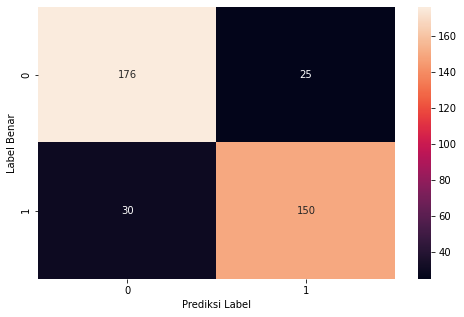

In [61]:
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(label_test, hasil_mnb), annot=True, fmt=".0f", ax=ax)
plt.xlabel("Prediksi Label")
plt.ylabel("Label Benar")
plt.show()

In [62]:
#Convert hasil ke list (hasil tadinya dalam bentuk ndarray)

l_hasil = list(hasil_mnb)
print("Prediksi tweet positif: " + str(l_hasil.count("positif")))
print("Prediksi tweet negatif: " + str(l_hasil.count("negatif")))
#print("Prediksi tweet irelevant: " + str(l_hasil.count("irrelevant")))
#print("Prediksi tweet netral: " + str(l_hasil.count("netral")))

num_positif = 100*(l_hasil.count("positif")/tweet_test.count())
num_negatif = 100*(l_hasil.count("negatif")/tweet_test.count())

print("Persentase tweet positif = {:.2f} %".format(num_positif))
print("Persentase tweet negatif = {:.2f} %".format(num_negatif))

acc = 100*accuracy_score(hasil_mnb,label_test)
recall = 100*(TP/(TP+FN))
specifity = 100*(TN/(TN+FP))
precision = 100*(TP/(TP+FP))
f1_score = 100*((2*TP)/((2*TP)+FP+FN))

print("Ketelitian = {:.2f} %".format(acc))
print("recall = {:.2f} %".format(recall))
print("precision = {:.2f} %".format(precision))
print("f1_score = {:.2f} %".format(f1_score))

Prediksi tweet positif: 175
Prediksi tweet negatif: 206
Persentase tweet positif = 45.93 %
Persentase tweet negatif = 54.07 %
Ketelitian = 85.56 %
recall = 83.33 %
precision = 85.71 %
f1_score = 84.51 %


In [63]:
print(classification_report(hasil_mnb, label_test))

              precision    recall  f1-score   support

     negatif       0.88      0.85      0.86       206
     positif       0.83      0.86      0.85       175

    accuracy                           0.86       381
   macro avg       0.85      0.86      0.85       381
weighted avg       0.86      0.86      0.86       381



try to applying the model to classify some sentence

In [586]:
coba = np.array(["terimakasih byu mantap banget dapet kuota gratis cuy"])
coba_vector = tfvec.transform(coba) 
sentimen = clf_mnb.predict(coba_vector)
print(sentimen)

['positif']


In [587]:
coba = np.array(["anjing bangsat baru kali ini pake operator jaringannya busuk banget"])
coba_vector = tfvec.transform(coba) 
sentimen = clf_mnb.predict(coba_vector)
print(sentimen)

['negatif']


save the model

In [588]:
# Nama fike tempat menyimpan data
model = 'model_sentiment_byu.data'
# Siapkan file untuk ditulis
f = open(model, 'wb')
# Simpan data nama siswa ke dalam file dengan perintah dump
pickle.dump(model_mnb, f)
f.close() # tutup setelah file digunakan

visualize the word with particular sentiment (positive, negative) with wordcloud

In [589]:
label_positif = data[data['label'] == "positif"]

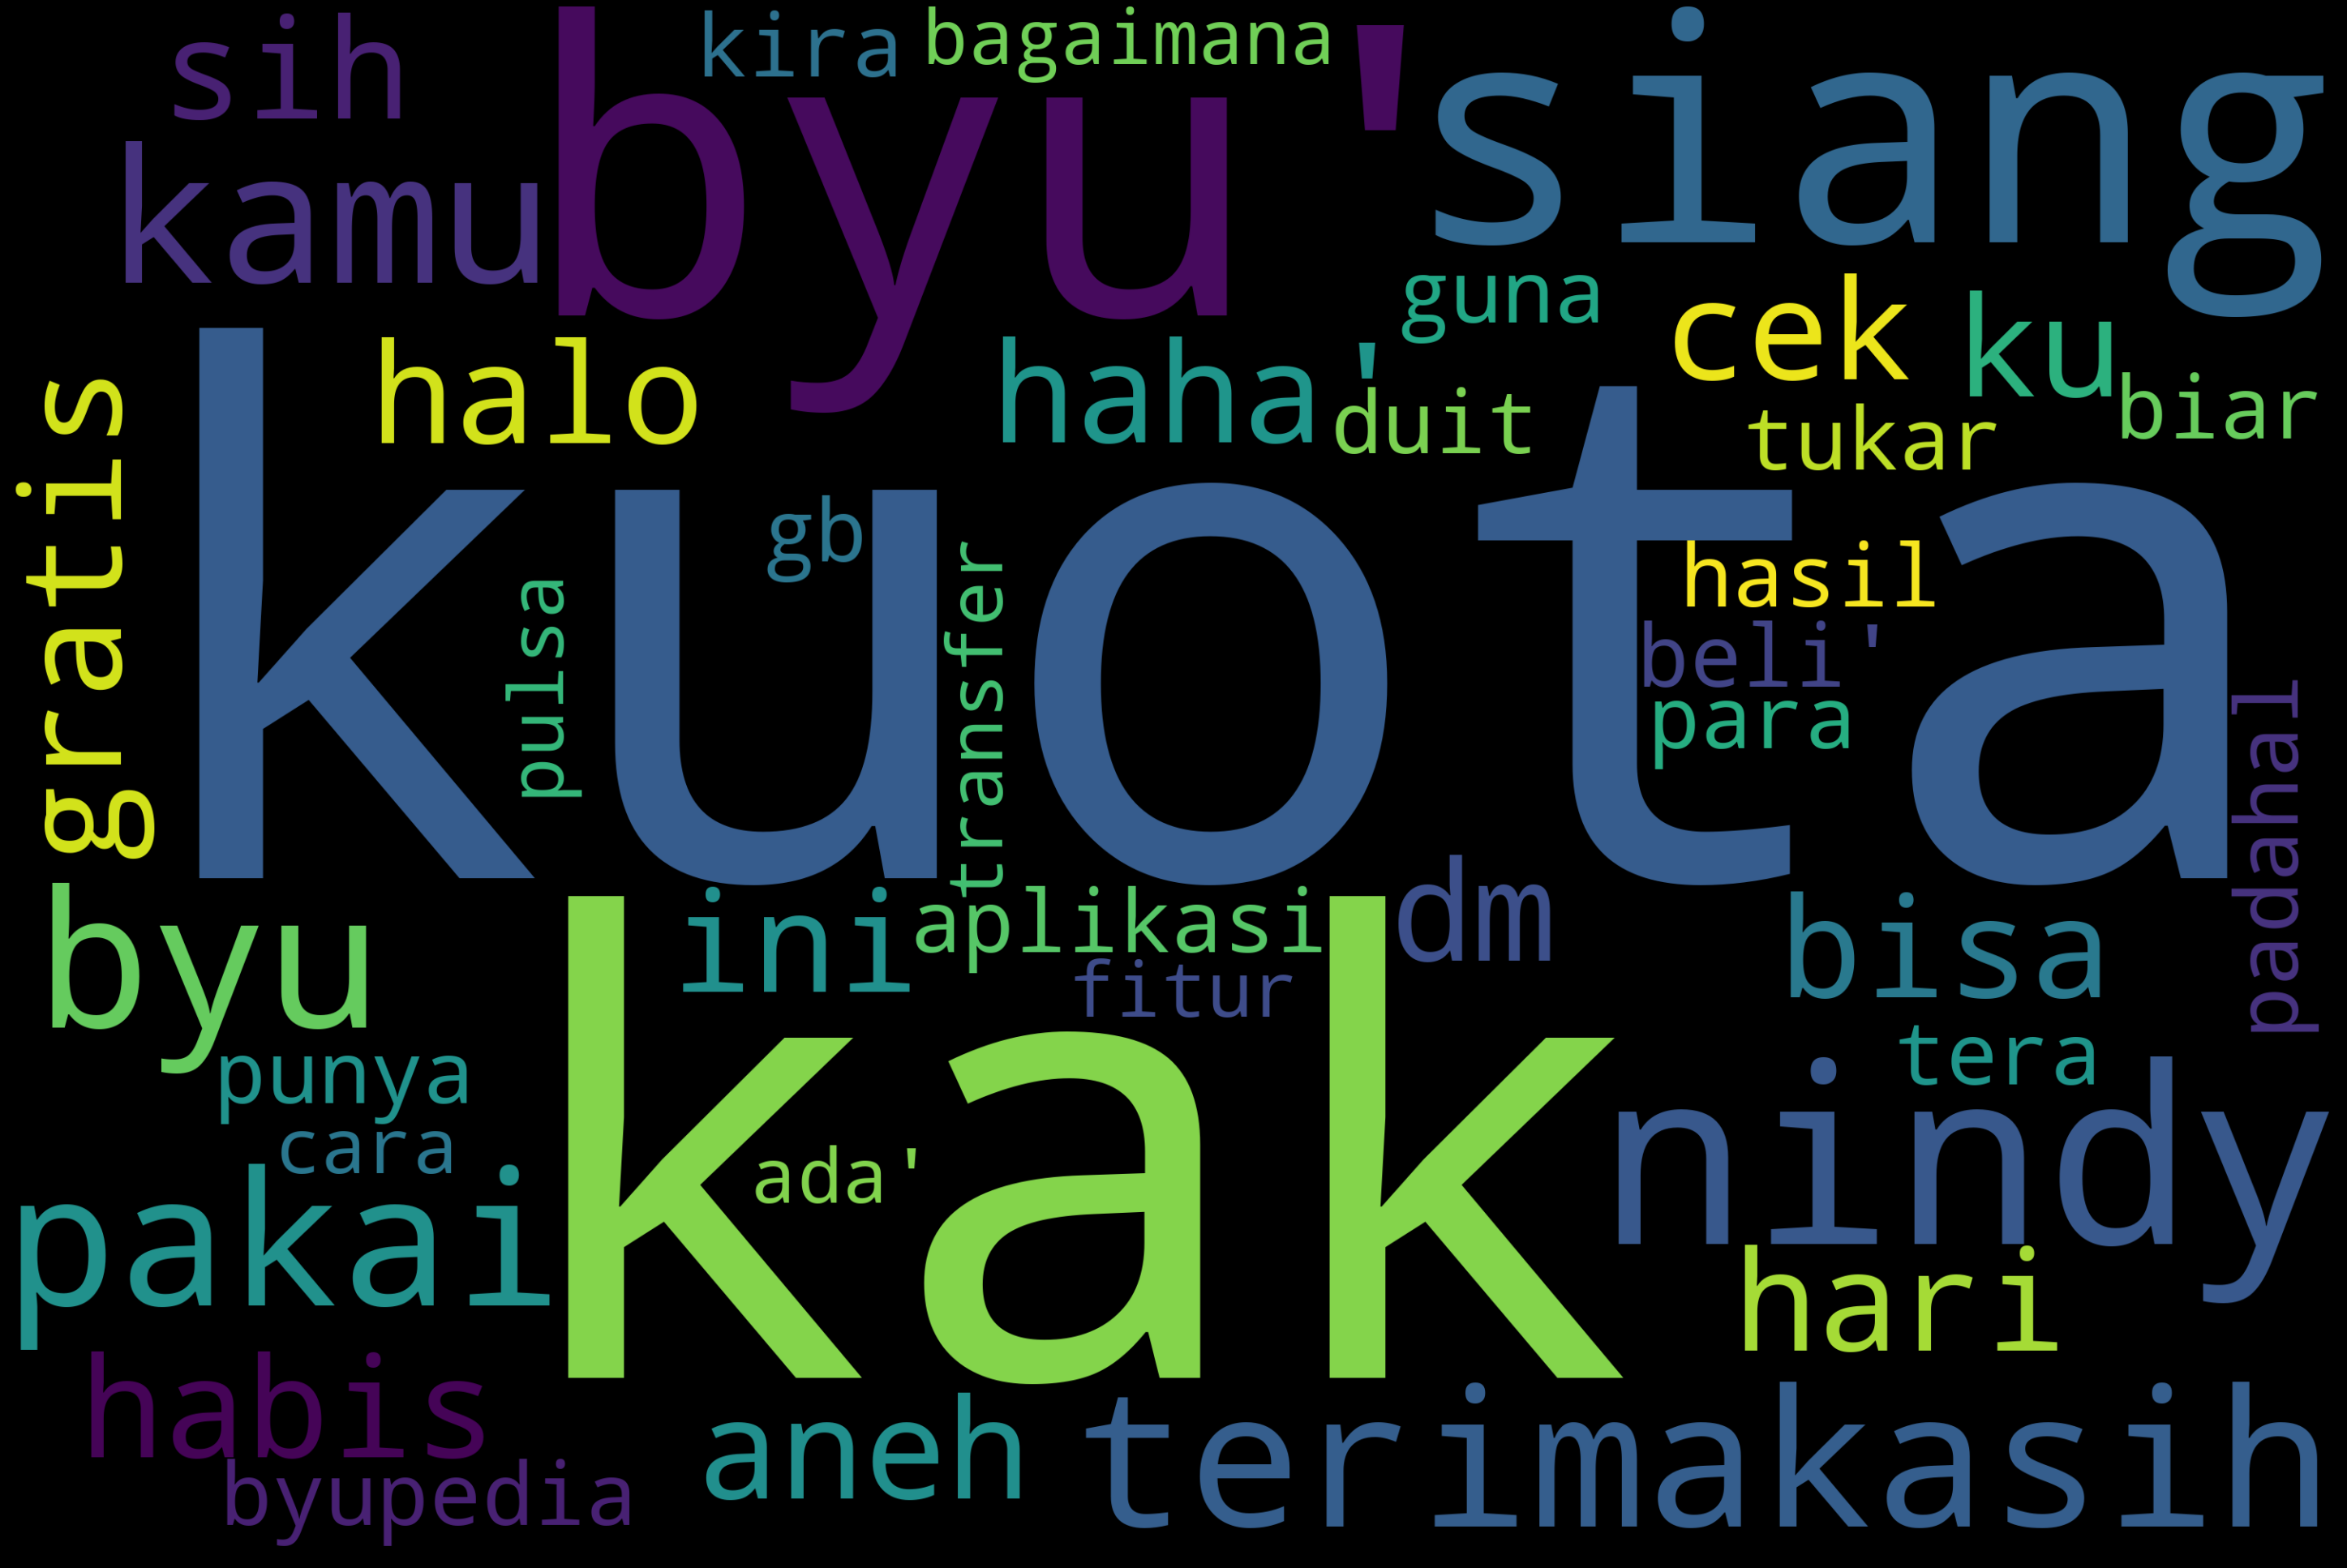

In [590]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = label_positif.text.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [591]:
label_negatif = data[data['label'] == "negatif"]

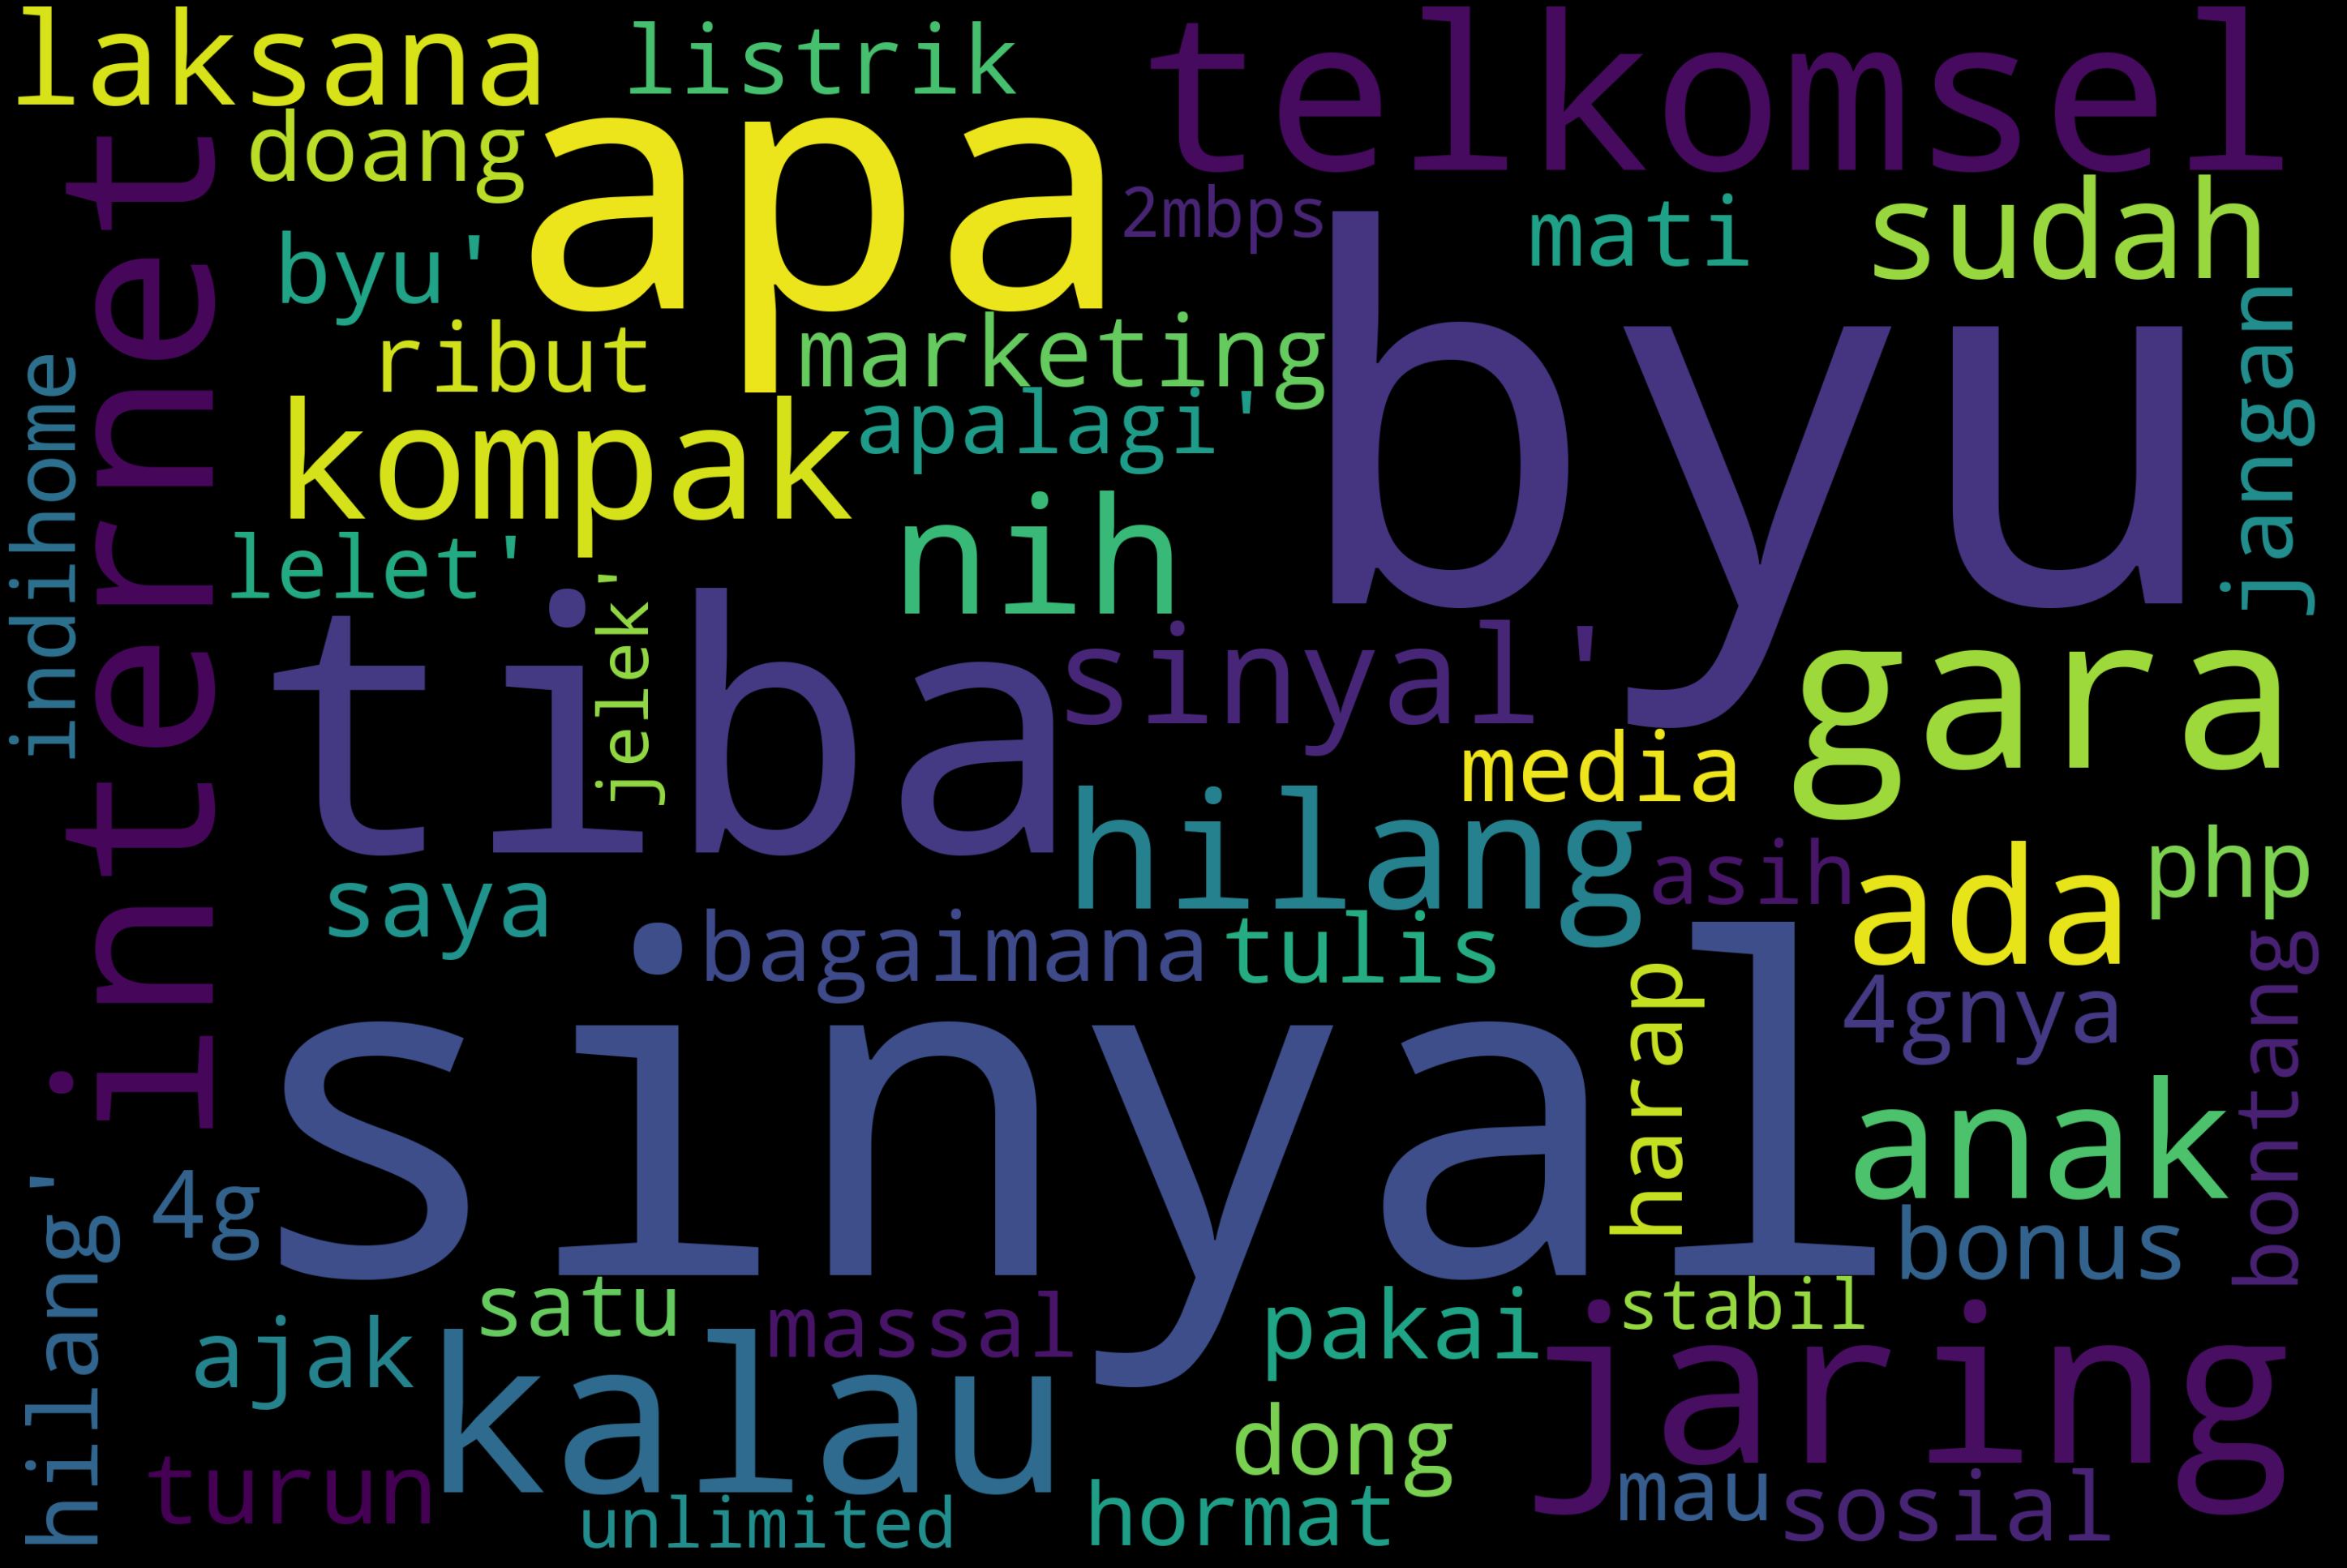

In [592]:
text = label_negatif.text.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

visualize the proportion of both sentiment (positive and negative)

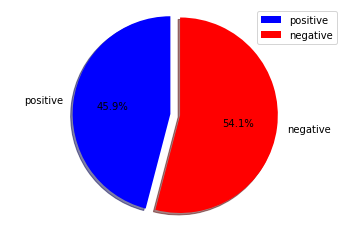

In [593]:
sizes = [l_hasil.count("positif"), l_hasil.count("negatif")]
labels = ['positive','negative']
colors = ['blue', 'red']
explode = (0.1,0)

#patches, texts = plt.pie(sizes, colors=colors, startangle=-270)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.legend(labels, loc="best")
plt.show()

visualize the most word appear in tweets

In [594]:
positif=data.loc[data.label=="positif"]
negatif=data.loc[data.label=="negatif"]

In [595]:
positif

created_at               source  \
1     2020-11-02 08:46:38+00:00  Twitter for Android   
4     2020-11-02 06:51:44+00:00  Twitter for Android   
7     2020-11-02 06:03:12+00:00  Twitter for Android   
9     2020-11-02 05:57:00+00:00  Twitter for Android   
11    2020-11-02 05:49:47+00:00  Twitter for Android   
...                         ...                  ...   
3789  2020-11-30 05:15:16+00:00  Twitter for Android   
3792  2020-11-30 05:00:57+00:00  Twitter for Android   
3799  2020-11-30 04:11:50+00:00  Twitter for Android   
3801  2020-11-30 05:47:12+00:00  Twitter for Android   
3803  2020-11-30 05:38:32+00:00  Twitter for Android   

                                                   text    label  
1     siang siang kuota gratis kak nindy terimakasih...  positif  
4           aneh kuota byu ku habis ini bisa pakai haha  positif  
7                             halo kak nindy cek dm byu  positif  
9     salah memang pilih provider byu hampir tahun l...  positif  
11    wow akhir provider internet bebas kamu bikin p...  positif  
...                                                 ...      ...  
3789                           positif 0 hari lahir byu  positif  
3792          asa pakai byu 9 bulan sebentar lahir haha  positif  
3799                                    terimakasih byu  positif  
3801  hari sih byupedia kuota tera aplikasi kamu 0 g...  positif  
3803  para guna byu kira biar tukar pakai duit bagai...  positif  

[1678 rows x 4 columns]

In [596]:
positiftest=data.loc[data.label=="positif", 'text']
negatiftest=data.loc[data.label=="negatif", 'text']

In [597]:
positiftest

1       siang siang kuota gratis kak nindy terimakasih...
4             aneh kuota byu ku habis ini bisa pakai haha
7                               halo kak nindy cek dm byu
9       salah memang pilih provider byu hampir tahun l...
11      wow akhir provider internet bebas kamu bikin p...
                              ...                        
3789                             positif 0 hari lahir byu
3792            asa pakai byu 9 bulan sebentar lahir haha
3799                                      terimakasih byu
3801    hari sih byupedia kuota tera aplikasi kamu 0 g...
3803    para guna byu kira biar tukar pakai duit bagai...
Name: text, Length: 1678, dtype: object

In [598]:
tekspositif='\n'.join(positiftest)
tekspositif

'siang siang kuota gratis kak nindy terimakasih kak byu\naneh kuota byu ku habis ini bisa pakai haha\nhalo kak nindy cek dm byu\nsalah memang pilih provider byu hampir tahun lalu sering tiba kuota gratis\nwow akhir provider internet bebas kamu bikin paket internet semua mau pesan sim kartu\nterimakasih nindy byu\nselamat 6 monthiversary terimakasih kuota gratis sayang byu\ncek dm byu dong\ntahan paket ya kak byu gila good deals\nwow akhir provider internet bebas kamu bikin paket internet semua mau pesan sim kartu\nwow akhir provider internet bebas kamu bikin paket internet semua mau pesan sim kartu\nmau tanya pulsa byu sama telkomsel sama sih di ubah\npunya aku dari byu utuh dong haha lupa melulu tiup\nterimakasih byu gtlt moga tak kecewa gtlt byu\nmemang benar guys kalian pakai kuota bikin makin aman jaya 2 mbps suka jadi paling andal tethering\nbajing telkom lelet byu nyata\nwifi error untung kemarin paket gratis byu\nbyu sambung hidup\nuntung byu hilang sinyal beli pakai akun sama m

In [599]:
teksnegatif='\n'.join(negatiftest)
teksnegatif

'apa apa tiba tiba telkomsel hilang sinyal anak nih byu kompak ada sinyal\nsudah laksana marketing bonus turun saya bagaimana dong byu\nbyu ajak ribut kalau mati listrik sinyal hilang\nbyu kemarin lelet benar hhhh\nhalo byu mau isi pulsa belum juga\ntelkomsel masalah apa bagaimana wifi tiba mati eh sinyal byu cuma hsdpa aneh\nadmin byu mau aktivasi login gmail begini melulu sim byu sim 1 wifi mati memang down apa bagaimana\nadmin kok kuota spotify sama youtube bisa pakai padahal banyak byu\ntelkomsel apa apa ini byu sama simpati bisa dua internet\nbyu jelek tumben\nbyu pakai gim rasa ping menang\nbyu tumben buruk kayak indihome sinyal\nhalo byu mau tanya ada pesan sim kartu baru sudah berapa hari lalu kok datang ya mungkin b\nmemang harus kandas kali awal pakai sinyal bagus makin sini makin parah padahal tahun kuota\nmon maaf kok youtube tiktok netflix bisa akses sama sekali byu browsing lelet\nbyu kok lelet anjing\nmau ganti provider saja kamu macet ml an byu\nandai aku ubah kuota tri

In [600]:
summarize(tekspositif, split=True)

['aneh kuota byu ku habis ini bisa pakai haha',
 'salah memang pilih provider byu hampir tahun lalu sering tiba kuota gratis',
 'selamat 6 monthiversary terimakasih kuota gratis sayang byu',
 'indosat byu keren aku gratis kuota terus',
 'beberapa hari lalu beli kartu perdana byu shopeeid terus tadi sampai cepat sekali kirim pakai',
 'baca baca thread kata kuota byu murah terus akhir beli pengin coba tau samarinda jaring enggak',
 'tetiba sms byu nyata sudah 1 tahun sama moga langgeng terus happy 1st anniversary',
 'halo byu mau tanya dong maksud kuota untung apa mohon maaf masih mula haha',
 'sayang sama nindy terus kasih bonus anniversary begini ya moga makin langgeng byu',
 'kaget tiba notifikasi kasih kuota gratis 2gb terimakasih banyak byu',
 'malam minggu guys kuota libur sama byu nya ready kan tani begadang malam',
 'suka pakai byu kok ada ya 100 ribu unlimited padahal cocok buat ajar',
 'enak beli nomor ponsel baru perlu pusing sama hasil undi tipu tipu pinjam abal-abal coba nom

In [601]:
summarize(teksnegatif, split=True)

['telkomsel masalah apa bagaimana wifi tiba mati eh sinyal byu cuma hsdpa aneh',
 'admin kok kuota spotify sama youtube bisa pakai padahal banyak byu',
 'halo byu mau tanya ada pesan sim kartu baru sudah berapa hari lalu kok datang ya mungkin b',
 'mon maaf kok youtube tiktok netflix bisa akses sama sekali byu browsing lelet',
 'memang mesti ganti provider byu makin gila jaring naik turun sering rto sial nya sih',
 'admin jaring nya bagus dong masa jelek byu',
 'admin mau tanya beberapa orang keluh jaring telkomsel susah pengaruh byu bagai informasi aku used dua jujur',
 'halo nindy byu telkomsel kualitas sinyal nya mohon tingkat saking bagus ping nya 0ms jangan',
 'admin byu lapor ganti kartu lama bagaimana mau saing sama tetangga belah',
 'admin byu kok ada sinyal begini genting padahal',
 'admin beli paket kok masuk terus byu di dm detail',
 'internetnya byu jelek anjir mati lampu begini aku kerja tugas woy ahelah kesal ingin menang',
 'mati lampu orang pakai byu bakal rasa hidup ku

In [602]:
keywords(tekspositif).split('\n')

['byu',
 'byus',
 'sama telkomsel',
 'hari',
 'apa',
 'yang',
 'nya',
 'enggak ada',
 'kuota gratis kak nindy terimakasih',
 'dong',
 'habis ini bisa pakai haha halo',
 'ubah punya aku dari',
 'tau',
 'promo',
 'bulan',
 'kamu bikin paket',
 'terus',
 'sih',
 'hilang sinyal beli',
 'coba',
 'ribu isi',
 'semua mau pesan sim kartu',
 'mbps suka jadi paling',
 'sayang',
 'kayak',
 'untung kemarin',
 'baik',
 'wow akhir',
 'sekarang',
 'sudah',
 'banyak',
 'lumayan',
 'tanya pulsa',
 'unlimited',
 'cuma',
 'mantap',
 'iny',
 'rumah',
 'anak',
 'enak',
 'murah',
 'kapan baru',
 'pas',
 'mana',
 'pagi admin',
 'pengin',
 'salah memang pilih provider',
 'anjir',
 'benar guys kalian',
 'sini',
 'dapat',
 'jaring',
 'bagaimana cara',
 'lama',
 'cinta',
 'kalau',
 'nyata wifi',
 'nomor ponsel',
 'bukan',
 'cepat sekali kirim',
 'lebih kencang',
 'ganti',
 'lagi',
 'aplikasi',
 'tahun lalu sering tiba',
 'tadi',
 'kok',
 'moga tak',
 'bagus',
 'kita',
 'tunggu',
 'harga topping',
 'internet',
 '

In [603]:
keywords(teksnegatif).split('\n')

['aku',
 'telkomsel hilang sinyal anak nih byu',
 'enggak',
 'kok kuota',
 'apa',
 'ada',
 'sama youtube bisa pakai padahal banyak',
 'jadi',
 'kemarin lelet benar',
 'terus',
 'anjing',
 'beli',
 'sial nya sih',
 'kartu baru',
 'begini melulu sim',
 'jelek tumben',
 'memang',
 'cuma',
 'deh',
 'lama',
 'lah',
 'aneh admin',
 'gila jaring naik',
 'tadi pas buka',
 'cepat',
 'bikin',
 'hari lalu',
 'mau isi pulsa belum',
 'anjir',
 'lagi',
 'woi',
 'sekarang',
 'sebal kenapa',
 'paket data',
 'hujan',
 'tonton',
 'sekali',
 'buruk kayak indihome',
 'buat main',
 'ganggu',
 'jangan',
 'ini',
 'sudah',
 'halo',
 'doang',
 'kesal',
 'nyata',
 'sumpah',
 'kalis',
 'masa',
 'turun saya bagaimana dong',
 'coba',
 'tiba',
 'koneksi',
 'jam gin',
 'parah',
 'masuk',
 'haha',
 'rumah',
 'error',
 'malah lag',
 'bangsat woy',
 'masalah',
 'akhir',
 'nomor',
 'langsung',
 'habis',
 'bagus makin sini',
 'stabil',
 'dua internet',
 'ganti provider saja kamu macet',
 'baik',
 'malam gmeet',
 'update 

In [604]:
def get_word_frequency(tweets, count_once_per_tweet=False):
   
    count_all = Counter()
    for tweet in tweets:
        tokens = word_tokenize(tweet)
        terms_all = [term for term in tokens]
        if count_once_per_tweet:
            terms_all = set(terms_all) 
        count_all.update(terms_all) # update the counter
    return count_all

In [605]:
pos_tweet = get_word_frequency(positif['text'].values)
neg_tweet = get_word_frequency(negatif['text'].values)

In [606]:
pos_tweet

Counter({'siang': 5,
         'kuota': 373,
         'gratis': 52,
         'kak': 18,
         'nindy': 72,
         'terimakasih': 162,
         'byu': 1562,
         'aneh': 6,
         'ku': 38,
         'habis': 100,
         'ini': 36,
         'bisa': 54,
         'pakai': 337,
         'haha': 84,
         'halo': 27,
         'cek': 52,
         'dm': 51,
         'salah': 11,
         'memang': 36,
         'pilih': 24,
         'provider': 145,
         'hampir': 5,
         'tahun': 47,
         'lalu': 19,
         'sering': 30,
         'tiba': 35,
         'wow': 86,
         'akhir': 135,
         'internet': 179,
         'bebas': 78,
         'kamu': 153,
         'bikin': 111,
         'paket': 223,
         'semua': 93,
         'mau': 234,
         'pesan': 79,
         'sim': 109,
         'kartu': 188,
         'selamat': 19,
         '6': 10,
         'monthiversary': 17,
         'sayang': 59,
         'dong': 79,
         'tahan': 4,
         'ya': 47,
       

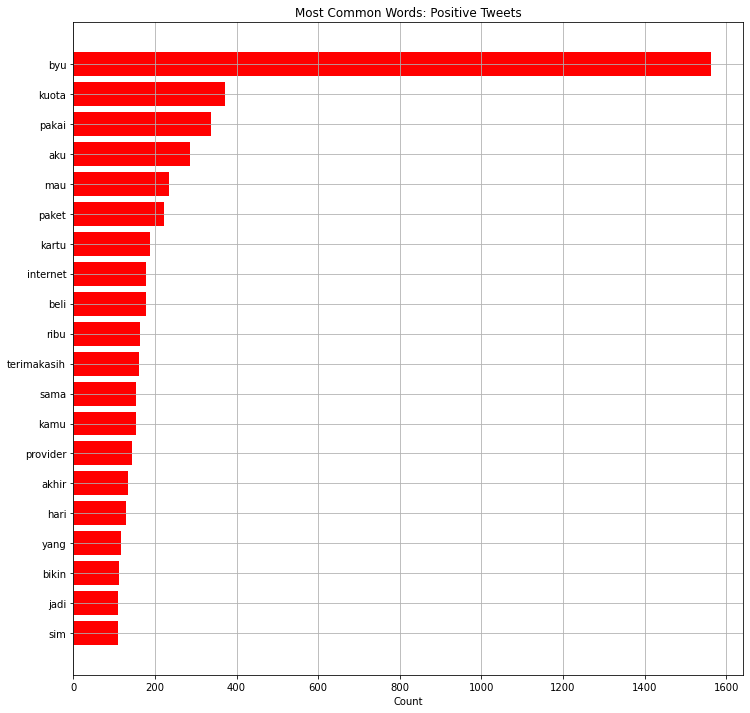

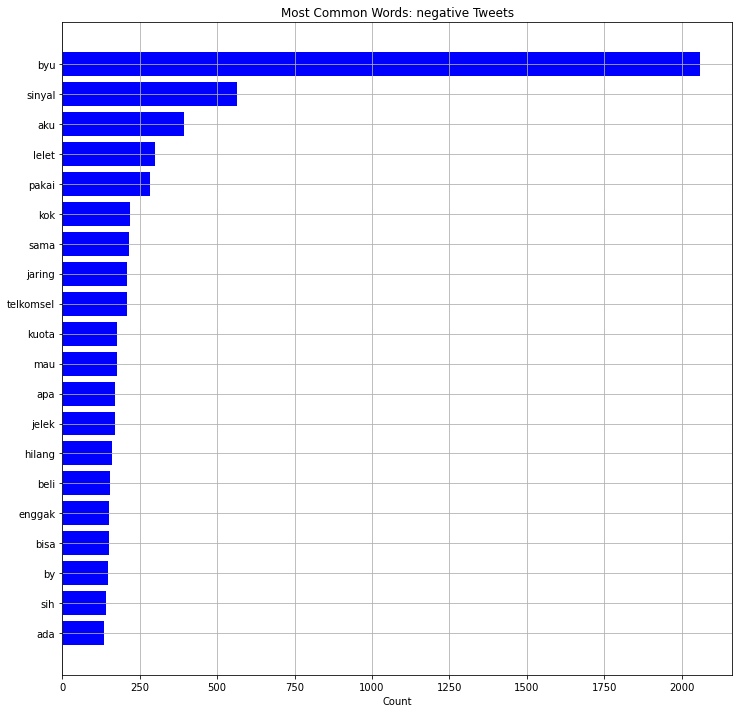

In [607]:
def plot_word_frequency(data, color='k', title='Twitter Word Count'):
    words, counts = zip(*data) 
    val = counts[::-1]   # sort the bars from longest to shortest
    words = words[::-1]
    pos = np.arange(len(data))+.5  # center the bars on the y axis
    
    plt.figure(figsize=(12,12))
    plt.barh(pos, val, align='center', color=color)
    plt.yticks(pos, words)
    plt.xlabel('Count')
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_word_frequency(pos_tweet.most_common(20),'r','Most Common Words: Positive Tweets')
plot_word_frequency(neg_tweet.most_common(20),'b','Most Common Words: negative Tweets')

visualize sentiment base on device

In [608]:
positifTest=data.loc[data.label=="positif"]
negatifTest=data.loc[data.label=="negatif"]

In [609]:
def get_source_label(source):
    jum = Counter(source).most_common()
    sour = []
    for sou, count in jum[:10]:
        sour.append(sou)
    return sour

def get_count_source(source,list_source):
    count_source = []
    list_source = pd.Series(list_source, dtype=object).tolist()
    for so in source:
        count = list_source.count(so)
        count_source.append(count)
     # update the counter
    return count_source

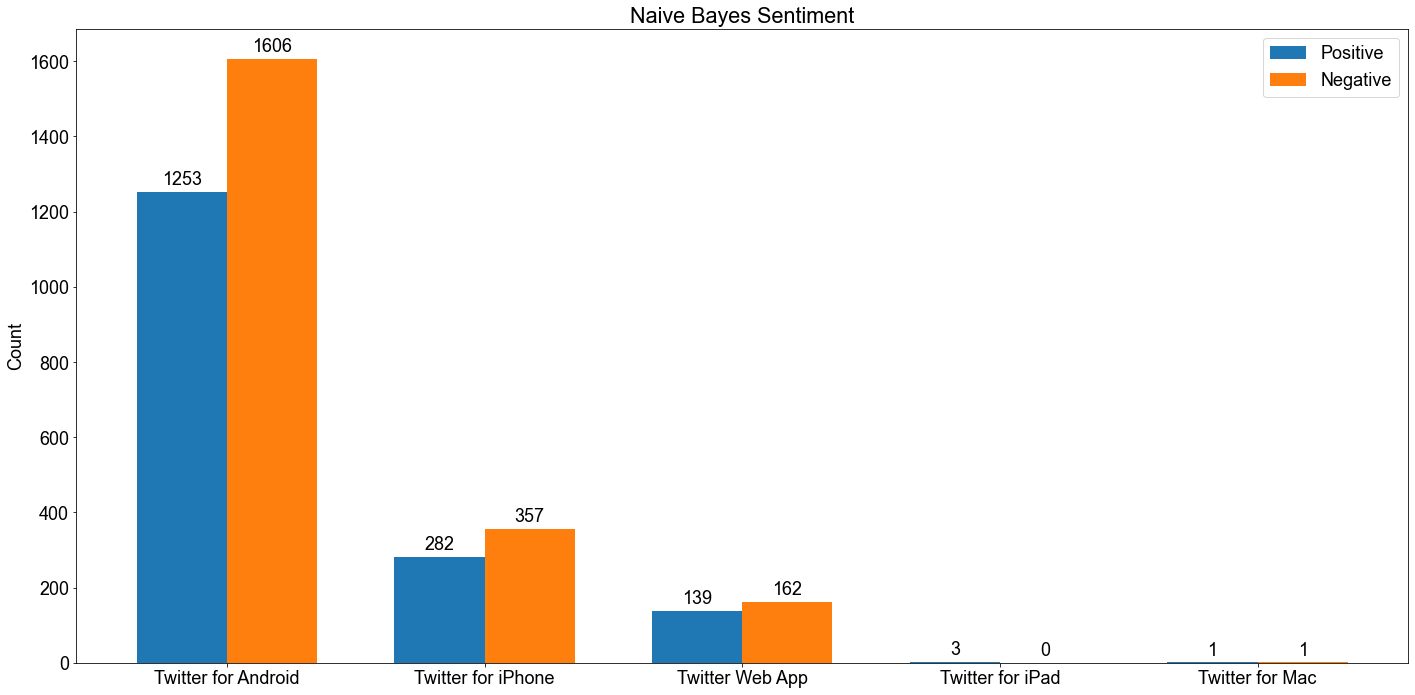

In [610]:
def show_count_sent(label,var1,var2,title):
    font = {'family' : 'arial',
            'weight' : 'normal',
            'size'   : 18}
    plt.rc('font', **font)

    labels = label
    positif = get_count_source(labels,var1)
    negatif = get_count_source(labels,var2)

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig = plt.figure(figsize=(20, 10))
    ax = fig.subplots()
    rects1 = ax.bar(x - width/2, positif, width, label='Positive')
    rects2 = ax.bar(x + width/2, negatif, width, label='Negative')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Count')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()

show_count_sent(get_source_label(data['source']),positifTest['source'],negatifTest['source'],'Naive Bayes Sentiment')

visualize the word with particular sentiment (positive, negative) with wordcloud base on device

In [611]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import imageio as imageio

In [612]:
def wordcloud (teks,title) :
    #background_mask = imageio.imread("speech-bubble.png")
    wc = WordCloud(background_color="black",
                   stopwords=STOPWORDS,
                   width=1800,
                   height=1400,)
                   #mask=background_mask)
    if not teks:
        teks = 'none'
    wordcloud = wc.generate(teks)
    return wordcloud

def display_wordcloud(wordcloud, title, n_components):
    print(title.title())
    plt.figure(figsize=(30, 8))
    j = np.ceil(n_components/4)
    for t in range(n_components):
        i=t+1
        plt.subplot(j, 4, i).set_title("sentimen #" + str(t))
        plt.plot()
        plt.imshow(wordcloud[t], cmap=plt.cm.jet, interpolation="bilinear", aspect='auto'); plt.xticks(()); plt.yticks(())
        plt.axis("off")
    fig.suptitle(title)
    plt.show()
    
def get_klas_tweet_nb(source,sentimen):
    source_data = data.loc[data.label==sentimen]
    sent_source_data = source_data.loc[source_data.source==source,'text']
    teks_data = " ".join(str(v) for v in sent_source_data)
    return teks_data

Twitter For Android


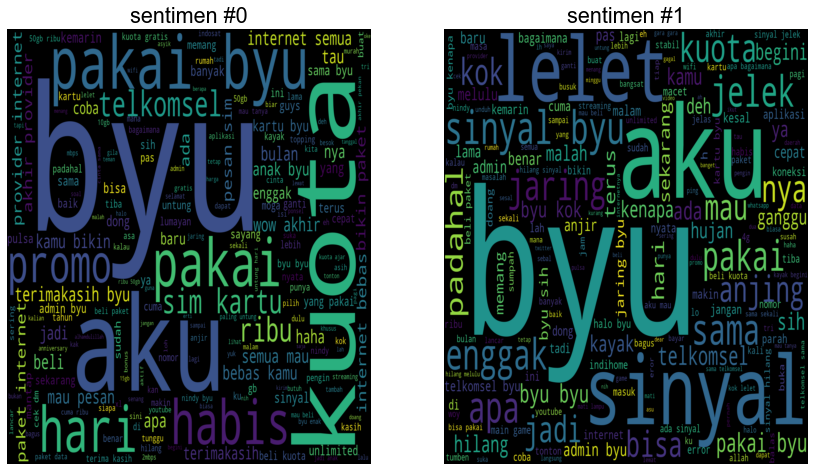

Twitter For Iphone


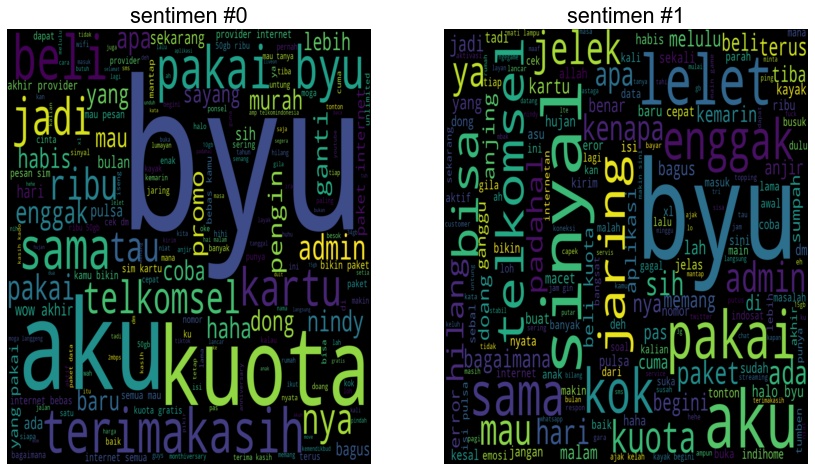

Twitter Web App


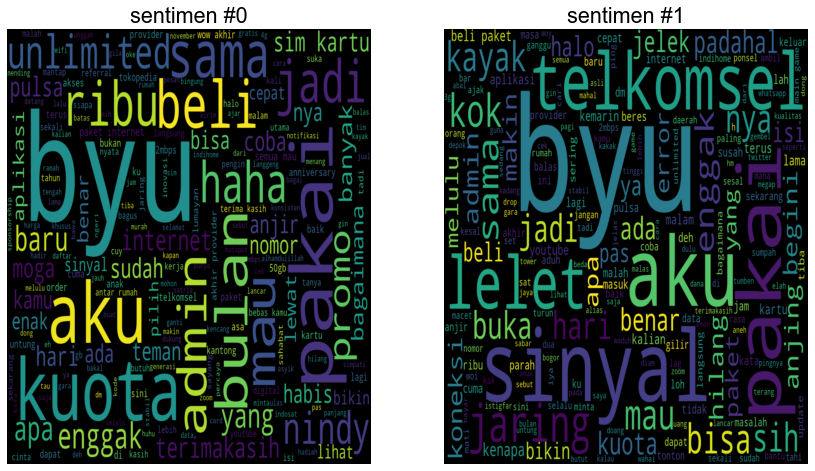

Twitter For Ipad


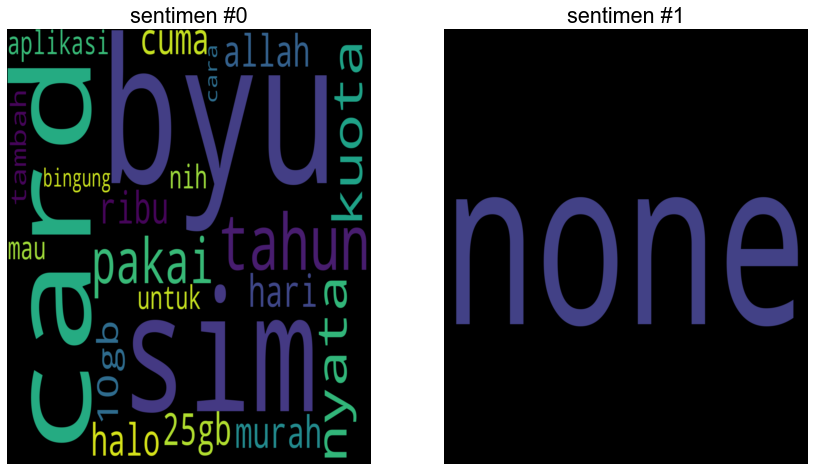

Twitter For Mac


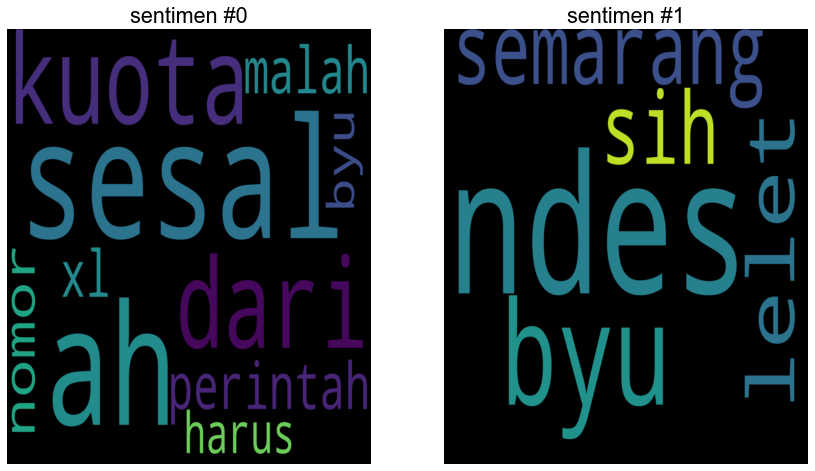

In [613]:
source = get_source_label(data['source'])

for i in source:
    wordcl = [wordcloud(get_klas_tweet_nb(i,"positif"),i),wordcloud(get_klas_tweet_nb(i,"negatif"),i)]
    display_wordcloud(wordcl, i, 2)